# U-net 23x under-sampling

# This was done in  Google cloud, using V100 GPUs


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Preparation

Note that I had to deal with several data coming from different places in different formats. I used Jupyter notebook to prepare the data and then run the network also using the jupyter notebook.

In [3]:
data_recon = scipy.io.loadmat('data/Training_23und_recon.mat')
data_truth = scipy.io.loadmat('data/Training_23und_truth.mat')

data_truth = data_truth['imagesTruth']
data_recon = data_recon['imagesResampled']


In [4]:
data_recon = data_recon.transpose()
data_truth = data_truth.transpose()
print(data_recon.shape)
print(data_truth.shape)

(1200, 20, 128, 128)
(1200, 20, 128, 128)


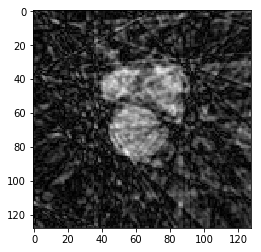

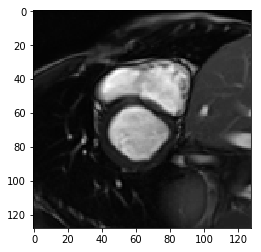

In [5]:
plt.imshow(data_recon[0,0,:,:], cmap='gray')
plt.show()
plt.imshow(data_truth[0,0,:,:], cmap='gray')
plt.show()

In [6]:
data_truth.shape

(1200, 20, 128, 128)

In [7]:
data_recon.shape

(1200, 20, 128, 128)

In [8]:
data_truth_channel = np.ndarray((1200,20,128,128,1))
data_recon_channel = np.ndarray((1200,20,128,128,1))

In [9]:
data_truth_channel[:,:,:,:,0] = data_truth
data_recon_channel[:,:,:,:,0] = data_recon
data_truth = data_truth_channel
data_recon = data_recon_channel

In [10]:
del data_truth_channel, data_recon_channel

In [11]:
print(data_recon.shape)
print(data_truth.shape)

(1200, 20, 128, 128, 1)
(1200, 20, 128, 128, 1)


In [12]:
data_recon = torch.from_numpy(data_recon)
data_truth = torch.from_numpy(data_truth)
data_recon = data_recon.float()
data_truth = data_truth.float()

In [13]:
print(data_recon.shape)
print(data_truth.shape)

torch.Size([1200, 20, 128, 128, 1])
torch.Size([1200, 20, 128, 128, 1])


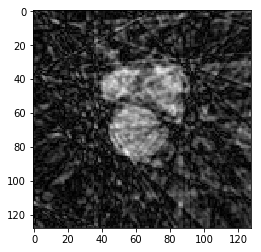

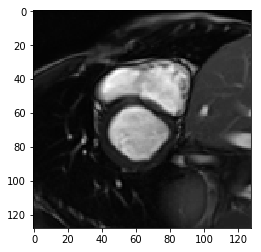

In [14]:
plt.imshow(data_recon[0,0,:,:,0], cmap='gray')
plt.show()
plt.imshow(data_truth[0,0,:,:,0], cmap='gray')
plt.show()

In [15]:
data_test_ = scipy.io.loadmat('data/Test_23und_recon.mat')
data_truth_ = scipy.io.loadmat('data/Test_23und_truth.mat')


In [16]:
test_truth = data_truth_['imagesTruth']
test_recon = data_test_['imagesResampled']
del data_test_, data_truth_

In [17]:
print(test_truth.shape)
print(test_recon.shape)
test_truth = test_truth.transpose()
test_recon = test_recon.transpose()
print(test_truth.shape)
print(test_recon.shape)

(128, 128, 20, 222)
(128, 128, 20, 222)
(222, 20, 128, 128)
(222, 20, 128, 128)


In [18]:
data_truth_channel = np.ndarray((222,20,128,128,1))
data_recon_channel = np.ndarray((222,20,128,128,1))

In [19]:
data_truth_channel[:,:,:,:,0] = test_truth
data_recon_channel[:,:,:,:,0] = test_recon
test_truth = data_truth_channel
test_recon = data_recon_channel

In [20]:
del data_truth_channel, data_recon_channel

In [21]:
print(test_truth.shape)
print(test_recon.shape)

(222, 20, 128, 128, 1)
(222, 20, 128, 128, 1)


In [22]:
test_recon = torch.from_numpy(test_recon)
test_truth = torch.from_numpy(test_truth)
test_recon = test_recon.float()
test_truth = test_truth.float()

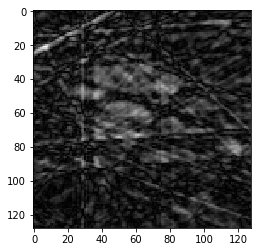

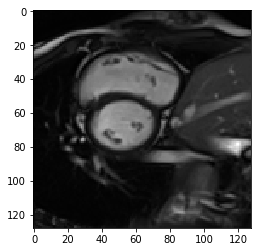

In [23]:
plt.imshow(test_recon[0,0,:,:,0], cmap='gray')
plt.show()
plt.imshow(test_truth[0,0,:,:,0], cmap='gray')
plt.show()

In [24]:
print(data_truth.shape)
print(data_recon.shape)
print(test_truth.shape)
print(test_recon.shape)


torch.Size([1200, 20, 128, 128, 1])
torch.Size([1200, 20, 128, 128, 1])
torch.Size([222, 20, 128, 128, 1])
torch.Size([222, 20, 128, 128, 1])


In [25]:
data_truth = data_truth.permute(0,4,2,3,1)
data_recon = data_recon.permute(0,4,2,3,1)
test_truth = test_truth.permute(0,4,2,3,1)
test_recon = test_recon.permute(0,4,2,3,1)

In [26]:
print(data_truth.shape)
print(data_recon.shape)
print(test_truth.shape)
print(test_recon.shape)



torch.Size([1200, 1, 128, 128, 20])
torch.Size([1200, 1, 128, 128, 20])
torch.Size([222, 1, 128, 128, 20])
torch.Size([222, 1, 128, 128, 20])


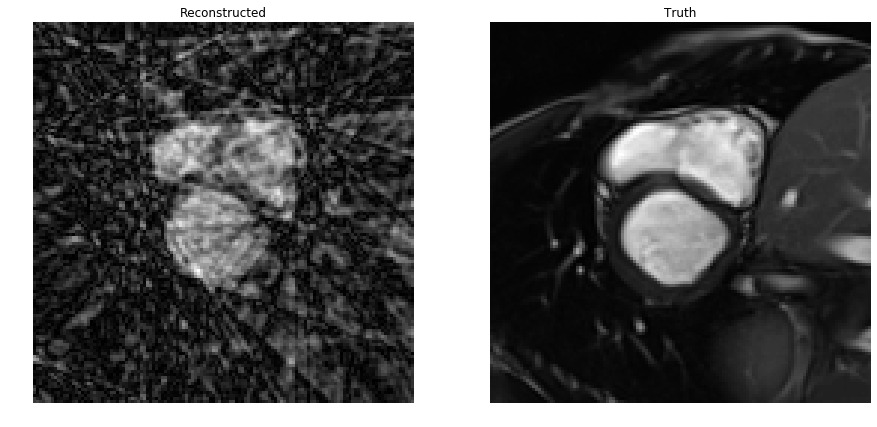

In [27]:
# Let's look at a smaple data again to check everything is the same
f, arr = plt.subplots(1,2,figsize=(15,15))
arr[0].imshow(data_recon[0,0,:,:,0], cmap='gray')
arr[0].set_title("Reconstructed")
arr[0].axis('off')
arr[1].imshow(data_truth[0,0,:,:,0], cmap='gray')
arr[1].set_title("Truth")
arr[1].axis('off');

# U-net

In [28]:
class unet(nn.Module):
    """
    Implementation of the U-net as in the Hauptmann et al.
    --------------
    inputs = Aliased data, 4D tensor, shape: (N_batch, N_channels, depth, height, width)
    The order of the depth, height and width doesn't really matter.
    --------------
    outputs---> De-aliased data, 4D tensor, shape(N_batch, N_channels, depth, height, width)    
    """
    def __init__(self, input_channel=1, first_output_channel=32, kernel_size=3):
        super(unet, self).__init__()
        self.kernel_size = kernel_size
        # All the convolutions used. The subscript is the level going down until to 3
        # and then goes upwards 
        # convi_i is the same convolution as i repeated but differnet input channels

        self.conv1 = nn.Conv3d(input_channel, first_output_channel, kernel_size, padding=1)
        # Default: self.conv1 = nn.Conv3d(1, 32, kernel_size, padding=1)
        self.conv1_1 = nn.Conv3d(first_output_channel, first_output_channel, kernel_size, padding=1)
        # Notice the differnece in the input channel compared to previous one

        self.conv2 = nn.Conv3d(first_output_channel, first_output_channel*2, kernel_size, padding=1)
        # Default: self.conv2 = nn.Conv3d(32, 64, kernel_size, padding=1)
        self.conv2_2 = nn.Conv3d(first_output_channel*2, first_output_channel*2, kernel_size, padding=1)

        self.conv3 = nn.Conv3d(first_output_channel*2, first_output_channel*2*2, kernel_size, padding=1)
        # Default: self.conv3 = nn.Conv3d(64, 128, kernel_size, padding=1)
        self.conv3_3 = nn.Conv3d(128, 128, kernel_size, padding=1)

        self.conv4 = nn.Conv3d(first_output_channel*2*2, first_output_channel*2, kernel_size, padding=1)
        # Default: self.conv4 = nn.Conv3d(128, 64, kernel_size, padding=1)
        self.conv4_4 = nn.Conv3d(first_output_channel*2, first_output_channel*2, kernel_size, padding=1)

        self.conv5 = nn.Conv3d(first_output_channel*2, first_output_channel, kernel_size, padding=1)
        # Default: self.conv5 = nn.Conv3d(64, 32, kernel_size, padding=1)
        self.conv5_5 = nn.Conv3d(first_output_channel, first_output_channel, kernel_size, padding=1)

        self.conv6 = nn.Conv3d(first_output_channel, input_channel , kernel_size, padding=1)
        # Default: self.conv6 = nn.Conv3d(32, 1 , kernel_size, padding=1)
        
        # Transposed convolutions for upsampling
        self.convT1 = nn.ConvTranspose3d(first_output_channel*2*2, first_output_channel*2, kernel_size, stride=(2,2,2), padding=1, output_padding=1)
        # Default: self.convT1 = nn.ConvTranspose3d(128, 64, kernel_size, stride=(2,2,2), padding=1, output_padding=1)
        self.convT2 = nn.ConvTranspose3d(first_output_channel*2, first_output_channel, kernel_size, stride=(2,2,2), padding=1, output_padding=1)
        # Default: self.convT2 = nn.ConvTranspose3d(64, 32, kernel_size, stride=(2,2,2), padding=1, output_padding=1)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, inputs):
        """
        1- Convolution, Convolution, pooling
        2- Convolution, Convolution, pooling
        3- Convolution, Convolution, upsampling
        4- Convolution, Convolution, upsampling
        5- Convolution, Convolution, Convolution
        6- Skip connection, Relu
        """
        conv1 = self.relu(self.conv1(inputs))
        conv1 = self.relu(self.conv1_1(conv1))
        pool1 = F.max_pool3d(conv1, 2)
        
        conv2 = self.relu(self.conv2(pool1))
        conv2 = self.relu(self.conv2_2(conv2))
        pool2 = F.max_pool3d(conv2, 2)   

        conv3 = self.relu(self.conv3(pool2))
        conv3 = self.relu(self.conv3_3(conv3))        
        conv3 = self.convT1(conv3)
        
        up1 = torch.cat((conv3, conv2), dim=1)

        conv4 = self.relu(self.conv4(up1))
        conv4 = self.relu(self.conv4_4(conv4))
        
        conv4 = self.convT2(conv4)

        up2 = torch.cat((conv4, conv1), dim=1)

        conv5 = self.relu(self.conv5(up2))
        conv5 = self.relu(self.conv5_5(conv5))
        
        conv6 = self.relu(self.conv6(conv5) + inputs)
        # conv6 is the output
        return conv6




In [29]:
model = unet().to(device)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [31]:
# Making sure data is fp32 for the model
data_recon = data_recon.float()
data_truth = data_truth.float()

In [39]:
datasets = torch.utils.data.TensorDataset(data_recon, data_truth)

In [33]:
datasets = torch.utils.data.TensorDataset(data_recon, data_truth)

In [40]:
train_loader = DataLoader(datasets, batch_size=8, shuffle=True)

In [35]:
test_point = test_recon[0:1]
test_point = test_point.to(device)

In [36]:
test_point = test_point.float()

In [37]:
import datetime

loss_vec = []
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    print('saving epoch {%d}'%0)
    checkpoint = {'model': unet(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'checkpoint_unetNormalised_23und_epoch__%d.pth'%0)
    for epoch in range(1, n_epochs + 1):
        i = 0
        loss_train = 0
        for imgs, labels in train_loader:
            
            #print("started")
            #imgs = imgs.float()
            #labels = labels.float()
            #print("===")
            #print(imgs.shape)
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            #k = k.to(device)
            #m = m.to(device)
            
            #print(imgs.dtype)
            #print(k.dtype)
            #print(m.dtype)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            
            optimizer.step()
            
            loss_train += loss.item()
            
            if i%100 == 0:
                print("Epoch: {}, Iteration: {}, Loss: {}, time: {}".format(epoch, i+1, loss_train, datetime.datetime.now()))
            i +=1
        loss_vec.append(loss_train)
        print(i)
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, float(loss_train)))
        prediction = model(test_point)
        prediction = prediction.to('cpu')
        prediction = prediction.detach()
        prediction = prediction.float()
        print(prediction.shape)
        plt.imshow(prediction[0,0,:,:,0], cmap='gray')
        plt.show()
        del prediction
        
        print('saving epoch {%d}'%epoch)
        checkpoint = {'model': unet(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
        torch.save(checkpoint, 'ckp_unetNormalised_23und_epoch_%d.pth'%epoch)
        
    

saving epoch {0}
Epoch: 1, Iteration: 1, Loss: 0.3644149601459503, time: 2019-08-03 01:42:34.231565
Epoch: 1, Iteration: 101, Loss: 32.150411278009415, time: 2019-08-03 01:44:15.179894
150
2019-08-03 01:45:04.639517 Epoch 1, Training loss 44.317239835858345
torch.Size([1, 1, 128, 128, 20])


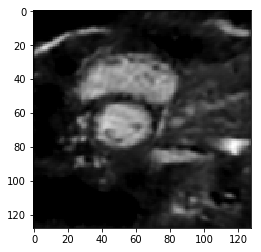

saving epoch {1}
Epoch: 2, Iteration: 1, Loss: 0.24439063668251038, time: 2019-08-03 01:45:05.946724
Epoch: 2, Iteration: 101, Loss: 19.57107263803482, time: 2019-08-03 01:46:46.863557
150
2019-08-03 01:47:36.294806 Epoch 2, Training loss 26.789437532424927
torch.Size([1, 1, 128, 128, 20])


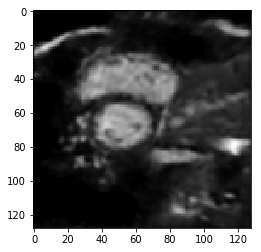

saving epoch {2}
Epoch: 3, Iteration: 1, Loss: 0.13614103198051453, time: 2019-08-03 01:47:37.511726
Epoch: 3, Iteration: 101, Loss: 11.318169698119164, time: 2019-08-03 01:49:18.441429
150
2019-08-03 01:50:07.882260 Epoch 3, Training loss 15.417642325162888
torch.Size([1, 1, 128, 128, 20])


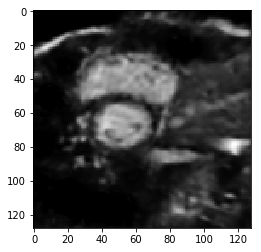

saving epoch {3}
Epoch: 4, Iteration: 1, Loss: 0.06610962003469467, time: 2019-08-03 01:50:09.093730
Epoch: 4, Iteration: 101, Loss: 6.210615165531635, time: 2019-08-03 01:51:50.003369
150
2019-08-03 01:52:39.489942 Epoch 4, Training loss 8.380009151995182
torch.Size([1, 1, 128, 128, 20])


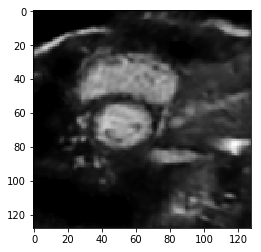

saving epoch {4}
Epoch: 5, Iteration: 1, Loss: 0.0314144492149353, time: 2019-08-03 01:52:40.708539
Epoch: 5, Iteration: 101, Loss: 3.2219293862581253, time: 2019-08-03 01:54:21.675899
150
2019-08-03 01:55:11.147343 Epoch 5, Training loss 4.320752706378698
torch.Size([1, 1, 128, 128, 20])


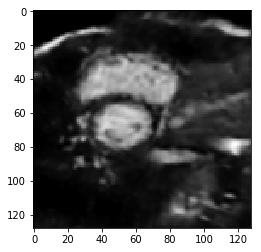

saving epoch {5}
Epoch: 6, Iteration: 1, Loss: 0.018168753013014793, time: 2019-08-03 01:55:12.364126
Epoch: 6, Iteration: 101, Loss: 1.5975774675607681, time: 2019-08-03 01:56:53.351141
150
2019-08-03 01:57:42.803628 Epoch 6, Training loss 2.149894111789763
torch.Size([1, 1, 128, 128, 20])


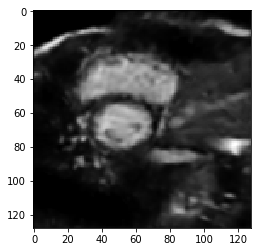

saving epoch {6}
Epoch: 7, Iteration: 1, Loss: 0.011445483192801476, time: 2019-08-03 01:57:44.020580
Epoch: 7, Iteration: 101, Loss: 0.804983155336231, time: 2019-08-03 01:59:24.989142
150
2019-08-03 02:00:14.472960 Epoch 7, Training loss 1.1079224511049688
torch.Size([1, 1, 128, 128, 20])


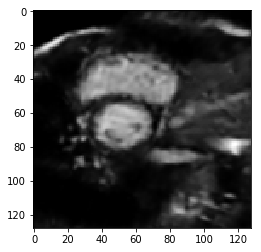

saving epoch {7}
Epoch: 8, Iteration: 1, Loss: 0.006586336996406317, time: 2019-08-03 02:00:15.685289
Epoch: 8, Iteration: 101, Loss: 0.46084917057305574, time: 2019-08-03 02:01:56.621789
150
2019-08-03 02:02:46.060611 Epoch 8, Training loss 0.6314026205800474
torch.Size([1, 1, 128, 128, 20])


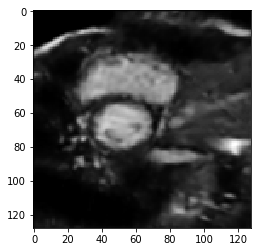

saving epoch {8}
Epoch: 9, Iteration: 1, Loss: 0.004798519425094128, time: 2019-08-03 02:02:47.288108
Epoch: 9, Iteration: 101, Loss: 0.31883794046007097, time: 2019-08-03 02:04:28.233131
150
2019-08-03 02:05:17.696836 Epoch 9, Training loss 0.45812961633782834
torch.Size([1, 1, 128, 128, 20])


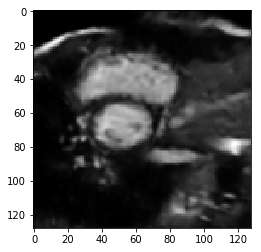

saving epoch {9}
Epoch: 10, Iteration: 1, Loss: 0.003174523590132594, time: 2019-08-03 02:05:18.913933
Epoch: 10, Iteration: 101, Loss: 0.2631354182958603, time: 2019-08-03 02:06:59.874877
150
2019-08-03 02:07:49.337521 Epoch 10, Training loss 0.3833645056001842
torch.Size([1, 1, 128, 128, 20])


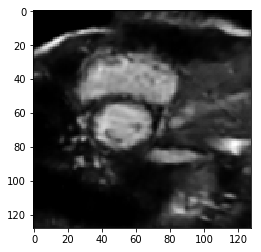

saving epoch {10}
Epoch: 11, Iteration: 1, Loss: 0.003287172643467784, time: 2019-08-03 02:07:50.553144
Epoch: 11, Iteration: 101, Loss: 0.24964134313631803, time: 2019-08-03 02:09:31.529644
150
2019-08-03 02:10:21.018590 Epoch 11, Training loss 0.3622485102387145
torch.Size([1, 1, 128, 128, 20])


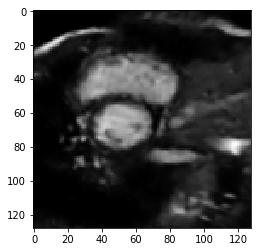

saving epoch {11}
Epoch: 12, Iteration: 1, Loss: 0.0016449976246804, time: 2019-08-03 02:10:22.226568
Epoch: 12, Iteration: 101, Loss: 0.231942004757002, time: 2019-08-03 02:12:03.197086
150
2019-08-03 02:12:52.662472 Epoch 12, Training loss 0.34390320302918553
torch.Size([1, 1, 128, 128, 20])


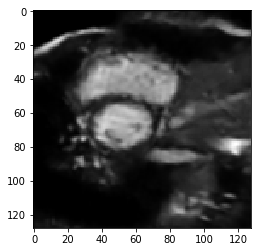

saving epoch {12}
Epoch: 13, Iteration: 1, Loss: 0.0022835289128124714, time: 2019-08-03 02:12:53.873446
Epoch: 13, Iteration: 101, Loss: 0.23156528710387647, time: 2019-08-03 02:14:34.858857
150
2019-08-03 02:15:24.330635 Epoch 13, Training loss 0.3411293469835073
torch.Size([1, 1, 128, 128, 20])


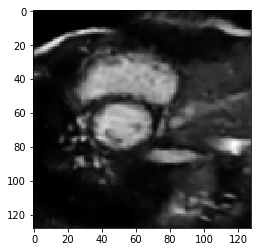

saving epoch {13}
Epoch: 14, Iteration: 1, Loss: 0.0037506259977817535, time: 2019-08-03 02:15:25.542863
Epoch: 14, Iteration: 101, Loss: 0.22323503287043422, time: 2019-08-03 02:17:06.507018
150
2019-08-03 02:17:55.966955 Epoch 14, Training loss 0.33579557307530195
torch.Size([1, 1, 128, 128, 20])


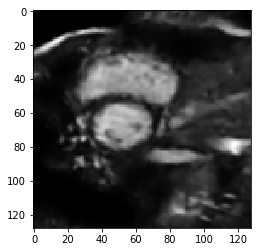

saving epoch {14}
Epoch: 15, Iteration: 1, Loss: 0.0020740709733217955, time: 2019-08-03 02:17:57.192451
Epoch: 15, Iteration: 101, Loss: 0.2216312139062211, time: 2019-08-03 02:19:38.154310
150
2019-08-03 02:20:27.641541 Epoch 15, Training loss 0.33214264968410134
torch.Size([1, 1, 128, 128, 20])


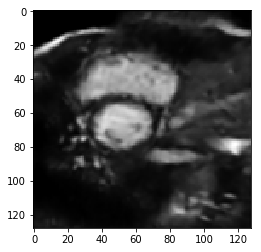

saving epoch {15}
Epoch: 16, Iteration: 1, Loss: 0.0022653404157608747, time: 2019-08-03 02:20:28.860736
Epoch: 16, Iteration: 101, Loss: 0.22573341382667422, time: 2019-08-03 02:22:09.865866
150
2019-08-03 02:22:59.344135 Epoch 16, Training loss 0.3289241227321327
torch.Size([1, 1, 128, 128, 20])


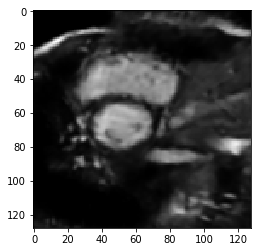

saving epoch {16}
Epoch: 17, Iteration: 1, Loss: 0.0017099283868446946, time: 2019-08-03 02:23:00.570146
Epoch: 17, Iteration: 101, Loss: 0.21677310054656118, time: 2019-08-03 02:24:41.571291
150
2019-08-03 02:25:31.056361 Epoch 17, Training loss 0.32622841733973473
torch.Size([1, 1, 128, 128, 20])


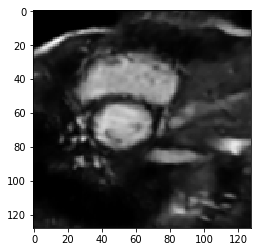

saving epoch {17}
Epoch: 18, Iteration: 1, Loss: 0.0023346864618360996, time: 2019-08-03 02:25:32.370366
Epoch: 18, Iteration: 101, Loss: 0.21119364991318434, time: 2019-08-03 02:27:13.391426
150
2019-08-03 02:28:02.856515 Epoch 18, Training loss 0.32322206220123917
torch.Size([1, 1, 128, 128, 20])


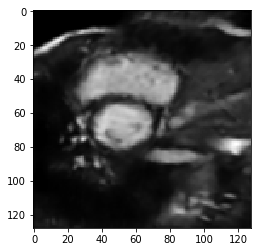

saving epoch {18}
Epoch: 19, Iteration: 1, Loss: 0.002165835816413164, time: 2019-08-03 02:28:04.077551
Epoch: 19, Iteration: 101, Loss: 0.20889207581058145, time: 2019-08-03 02:29:45.066718
150
2019-08-03 02:30:34.515146 Epoch 19, Training loss 0.3109881894197315
torch.Size([1, 1, 128, 128, 20])


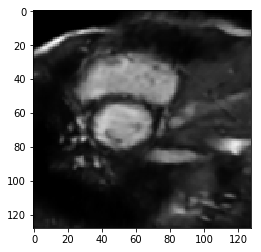

saving epoch {19}
Epoch: 20, Iteration: 1, Loss: 0.0020222910679876804, time: 2019-08-03 02:30:35.727633
Epoch: 20, Iteration: 101, Loss: 0.20641932112630457, time: 2019-08-03 02:32:16.666791
150
2019-08-03 02:33:06.141887 Epoch 20, Training loss 0.31521360436454415
torch.Size([1, 1, 128, 128, 20])


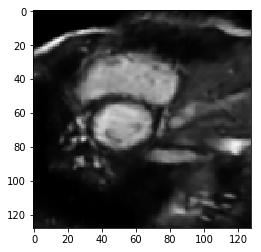

saving epoch {20}
Epoch: 21, Iteration: 1, Loss: 0.0017542305868119001, time: 2019-08-03 02:33:07.360579
Epoch: 21, Iteration: 101, Loss: 0.2062114473665133, time: 2019-08-03 02:34:48.349959
150
2019-08-03 02:35:37.796962 Epoch 21, Training loss 0.31041522428859025
torch.Size([1, 1, 128, 128, 20])


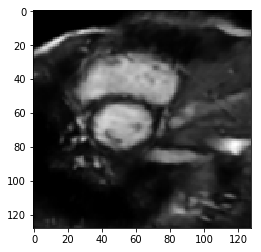

saving epoch {21}
Epoch: 22, Iteration: 1, Loss: 0.004257828462868929, time: 2019-08-03 02:35:39.008264
Epoch: 22, Iteration: 101, Loss: 0.1953024216927588, time: 2019-08-03 02:37:20.031930
150
2019-08-03 02:38:09.493950 Epoch 22, Training loss 0.2990115890279412
torch.Size([1, 1, 128, 128, 20])


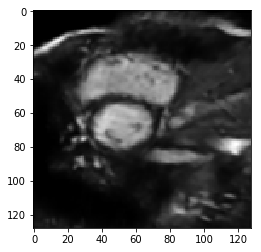

saving epoch {22}
Epoch: 23, Iteration: 1, Loss: 0.00167214369866997, time: 2019-08-03 02:38:10.706954
Epoch: 23, Iteration: 101, Loss: 0.19938500213902444, time: 2019-08-03 02:39:51.690255
150
2019-08-03 02:40:41.161375 Epoch 23, Training loss 0.3016940689412877
torch.Size([1, 1, 128, 128, 20])


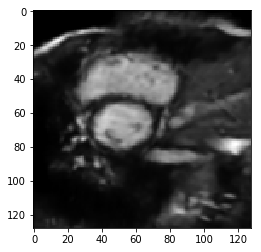

saving epoch {23}
Epoch: 24, Iteration: 1, Loss: 0.0019323121523484588, time: 2019-08-03 02:40:42.376905
Epoch: 24, Iteration: 101, Loss: 0.19600537838414311, time: 2019-08-03 02:42:23.366845
150
2019-08-03 02:43:12.857124 Epoch 24, Training loss 0.290535508771427
torch.Size([1, 1, 128, 128, 20])


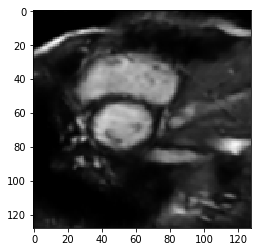

saving epoch {24}
Epoch: 25, Iteration: 1, Loss: 0.0015130772953853011, time: 2019-08-03 02:43:14.076705
Epoch: 25, Iteration: 101, Loss: 0.19442603667266667, time: 2019-08-03 02:44:55.051767
150
2019-08-03 02:45:44.505727 Epoch 25, Training loss 0.2855053989915177
torch.Size([1, 1, 128, 128, 20])


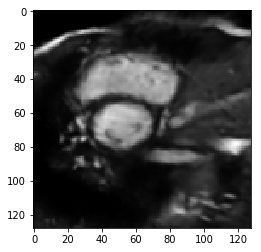

saving epoch {25}
Epoch: 26, Iteration: 1, Loss: 0.001969181466847658, time: 2019-08-03 02:45:45.722486
Epoch: 26, Iteration: 101, Loss: 0.18432159326039255, time: 2019-08-03 02:47:26.654912
150
2019-08-03 02:48:16.082171 Epoch 26, Training loss 0.2791510709794238
torch.Size([1, 1, 128, 128, 20])


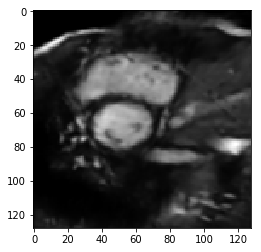

saving epoch {26}
Epoch: 27, Iteration: 1, Loss: 0.0025225223507732153, time: 2019-08-03 02:48:17.326285
Epoch: 27, Iteration: 101, Loss: 0.17711467610206455, time: 2019-08-03 02:49:58.283647
150
2019-08-03 02:50:47.764161 Epoch 27, Training loss 0.2643588286591694
torch.Size([1, 1, 128, 128, 20])


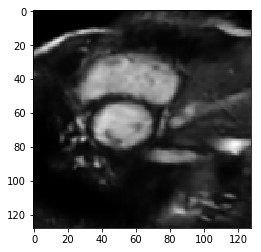

saving epoch {27}
Epoch: 28, Iteration: 1, Loss: 0.001372411148622632, time: 2019-08-03 02:50:48.981736
Epoch: 28, Iteration: 101, Loss: 0.17551368626300246, time: 2019-08-03 02:52:29.922958
150
2019-08-03 02:53:19.368103 Epoch 28, Training loss 0.2593106817221269
torch.Size([1, 1, 128, 128, 20])


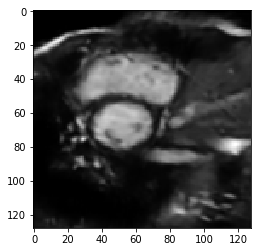

saving epoch {28}
Epoch: 29, Iteration: 1, Loss: 0.0015333377523347735, time: 2019-08-03 02:53:20.585469
Epoch: 29, Iteration: 101, Loss: 0.17568536242470145, time: 2019-08-03 02:55:01.491938
150
2019-08-03 02:55:50.947743 Epoch 29, Training loss 0.25802088563796133
torch.Size([1, 1, 128, 128, 20])


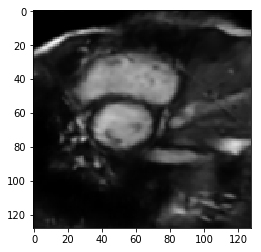

saving epoch {29}
Epoch: 30, Iteration: 1, Loss: 0.0018398521933704615, time: 2019-08-03 02:55:52.170958
Epoch: 30, Iteration: 101, Loss: 0.17203900287859142, time: 2019-08-03 02:57:33.172708
150
2019-08-03 02:58:22.642380 Epoch 30, Training loss 0.2523700052406639
torch.Size([1, 1, 128, 128, 20])


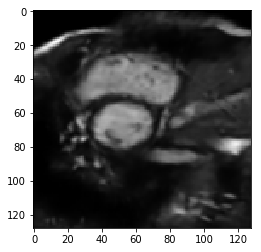

saving epoch {30}
Epoch: 31, Iteration: 1, Loss: 0.002820473164319992, time: 2019-08-03 02:58:23.850294
Epoch: 31, Iteration: 101, Loss: 0.1683931645238772, time: 2019-08-03 03:00:04.778051
150
2019-08-03 03:00:54.269552 Epoch 31, Training loss 0.24508037976920605
torch.Size([1, 1, 128, 128, 20])


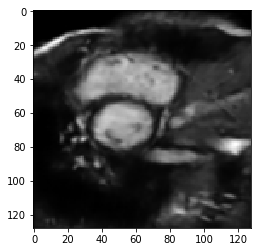

saving epoch {31}
Epoch: 32, Iteration: 1, Loss: 0.0015492321690544486, time: 2019-08-03 03:00:55.480203
Epoch: 32, Iteration: 101, Loss: 0.16058653593063354, time: 2019-08-03 03:02:36.470952
150
2019-08-03 03:03:25.934506 Epoch 32, Training loss 0.24240734847262502
torch.Size([1, 1, 128, 128, 20])


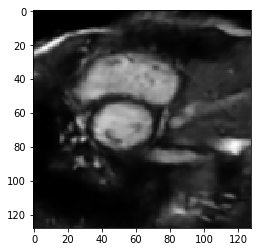

saving epoch {32}
Epoch: 33, Iteration: 1, Loss: 0.0018567724619060755, time: 2019-08-03 03:03:27.145478
Epoch: 33, Iteration: 101, Loss: 0.16016825032420456, time: 2019-08-03 03:05:08.127219
150
2019-08-03 03:05:57.608933 Epoch 33, Training loss 0.24250439531169832
torch.Size([1, 1, 128, 128, 20])


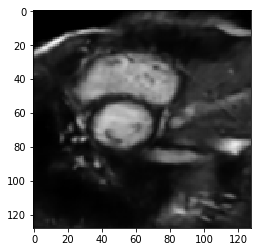

saving epoch {33}
Epoch: 34, Iteration: 1, Loss: 0.0013051952701061964, time: 2019-08-03 03:05:58.823541
Epoch: 34, Iteration: 101, Loss: 0.14685118664056063, time: 2019-08-03 03:07:39.801385
150
2019-08-03 03:08:29.281238 Epoch 34, Training loss 0.22062570718117058
torch.Size([1, 1, 128, 128, 20])


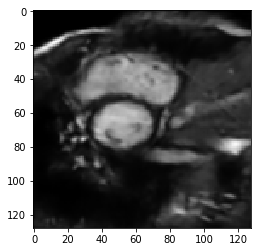

saving epoch {34}
Epoch: 35, Iteration: 1, Loss: 0.0010372345568612218, time: 2019-08-03 03:08:30.583492
Epoch: 35, Iteration: 101, Loss: 0.14401803282089531, time: 2019-08-03 03:10:11.500242
150
2019-08-03 03:11:00.933198 Epoch 35, Training loss 0.21505338291171938
torch.Size([1, 1, 128, 128, 20])


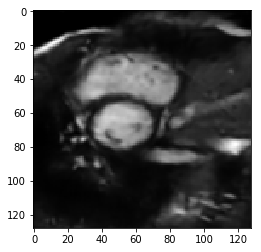

saving epoch {35}
Epoch: 36, Iteration: 1, Loss: 0.0012710955925285816, time: 2019-08-03 03:11:02.142344
Epoch: 36, Iteration: 101, Loss: 0.14854591595940292, time: 2019-08-03 03:12:43.116790
150
2019-08-03 03:13:32.587726 Epoch 36, Training loss 0.22359843272715807
torch.Size([1, 1, 128, 128, 20])


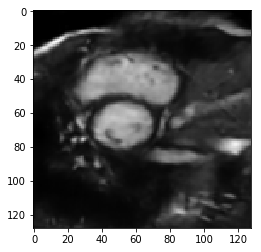

saving epoch {36}
Epoch: 37, Iteration: 1, Loss: 0.0010695134988054633, time: 2019-08-03 03:13:33.800909
Epoch: 37, Iteration: 101, Loss: 0.1451266982476227, time: 2019-08-03 03:15:14.741438
150
2019-08-03 03:16:04.199418 Epoch 37, Training loss 0.21747262764256448
torch.Size([1, 1, 128, 128, 20])


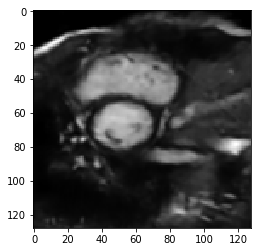

saving epoch {37}
Epoch: 38, Iteration: 1, Loss: 0.0013489339035004377, time: 2019-08-03 03:16:05.405405
Epoch: 38, Iteration: 101, Loss: 0.14255761541426182, time: 2019-08-03 03:17:46.375051
150
2019-08-03 03:18:35.840475 Epoch 38, Training loss 0.21060861623845994
torch.Size([1, 1, 128, 128, 20])


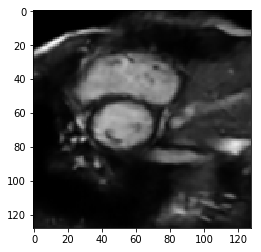

saving epoch {38}
Epoch: 39, Iteration: 1, Loss: 0.0011526837479323149, time: 2019-08-03 03:18:37.050781
Epoch: 39, Iteration: 101, Loss: 0.14141373516758904, time: 2019-08-03 03:20:18.038009
150
2019-08-03 03:21:07.539768 Epoch 39, Training loss 0.20807349687675014
torch.Size([1, 1, 128, 128, 20])


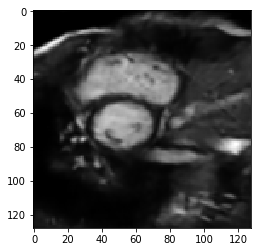

saving epoch {39}
Epoch: 40, Iteration: 1, Loss: 0.0011840126244351268, time: 2019-08-03 03:21:08.754676
Epoch: 40, Iteration: 101, Loss: 0.1378900849376805, time: 2019-08-03 03:22:49.704852
150
2019-08-03 03:23:39.174428 Epoch 40, Training loss 0.20367571717360988
torch.Size([1, 1, 128, 128, 20])


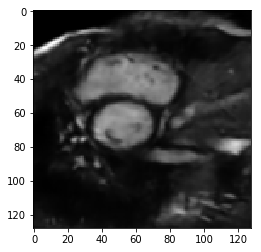

saving epoch {40}
Epoch: 41, Iteration: 1, Loss: 0.001178761012852192, time: 2019-08-03 03:23:40.390822
Epoch: 41, Iteration: 101, Loss: 0.1402512063505128, time: 2019-08-03 03:25:21.376033
150
2019-08-03 03:26:10.840640 Epoch 41, Training loss 0.2043659336050041
torch.Size([1, 1, 128, 128, 20])


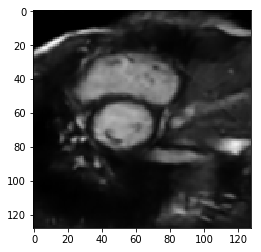

saving epoch {41}
Epoch: 42, Iteration: 1, Loss: 0.002098183613270521, time: 2019-08-03 03:26:12.055060
Epoch: 42, Iteration: 101, Loss: 0.13466748234350234, time: 2019-08-03 03:27:52.998131
150
2019-08-03 03:28:42.473664 Epoch 42, Training loss 0.1995823643519543
torch.Size([1, 1, 128, 128, 20])


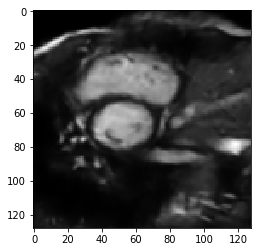

saving epoch {42}
Epoch: 43, Iteration: 1, Loss: 0.001210524351336062, time: 2019-08-03 03:28:43.685040
Epoch: 43, Iteration: 101, Loss: 0.1286695707240142, time: 2019-08-03 03:30:24.680280
150
2019-08-03 03:31:14.168511 Epoch 43, Training loss 0.19645675702486187
torch.Size([1, 1, 128, 128, 20])


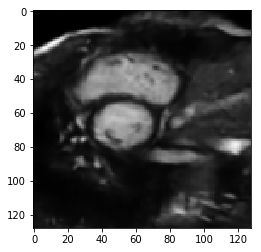

saving epoch {43}
Epoch: 44, Iteration: 1, Loss: 0.0010834098793566227, time: 2019-08-03 03:31:15.389135
Epoch: 44, Iteration: 101, Loss: 0.12969125690869987, time: 2019-08-03 03:32:56.384254
150
2019-08-03 03:33:45.858353 Epoch 44, Training loss 0.19399248785339296
torch.Size([1, 1, 128, 128, 20])


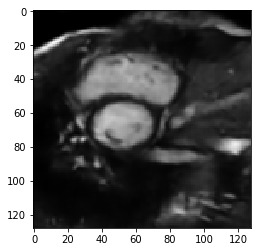

saving epoch {44}
Epoch: 45, Iteration: 1, Loss: 0.0010479619959369302, time: 2019-08-03 03:33:47.080889
Epoch: 45, Iteration: 101, Loss: 0.13041697395965457, time: 2019-08-03 03:35:28.090570
150
2019-08-03 03:36:17.574163 Epoch 45, Training loss 0.18998883612221107
torch.Size([1, 1, 128, 128, 20])


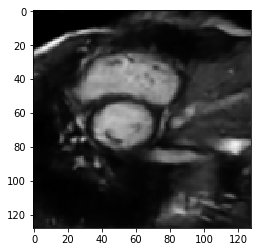

saving epoch {45}
Epoch: 46, Iteration: 1, Loss: 0.0018579598981887102, time: 2019-08-03 03:36:18.797976
Epoch: 46, Iteration: 101, Loss: 0.12434965919237584, time: 2019-08-03 03:37:59.804981
150
2019-08-03 03:38:49.247562 Epoch 46, Training loss 0.19095236086286604
torch.Size([1, 1, 128, 128, 20])


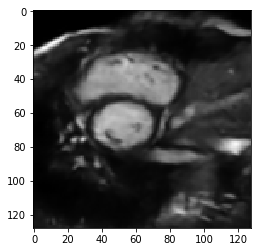

saving epoch {46}
Epoch: 47, Iteration: 1, Loss: 0.0009249270078726113, time: 2019-08-03 03:38:50.459456
Epoch: 47, Iteration: 101, Loss: 0.13488173560472205, time: 2019-08-03 03:40:31.435160
150
2019-08-03 03:41:20.921358 Epoch 47, Training loss 0.19399036618415266
torch.Size([1, 1, 128, 128, 20])


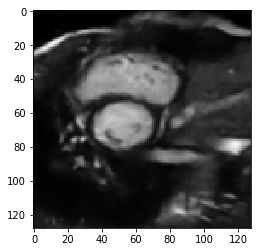

saving epoch {47}
Epoch: 48, Iteration: 1, Loss: 0.0013741508591920137, time: 2019-08-03 03:41:22.132199
Epoch: 48, Iteration: 101, Loss: 0.12556257232790813, time: 2019-08-03 03:43:03.128099
150
2019-08-03 03:43:52.593536 Epoch 48, Training loss 0.1816517551196739
torch.Size([1, 1, 128, 128, 20])


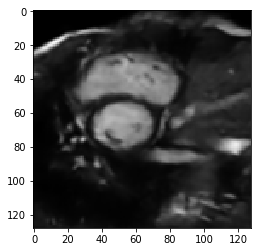

saving epoch {48}
Epoch: 49, Iteration: 1, Loss: 0.0008919585379771888, time: 2019-08-03 03:43:53.806620
Epoch: 49, Iteration: 101, Loss: 0.1172631168155931, time: 2019-08-03 03:45:34.756522
150
2019-08-03 03:46:24.213284 Epoch 49, Training loss 0.1793872052221559
torch.Size([1, 1, 128, 128, 20])


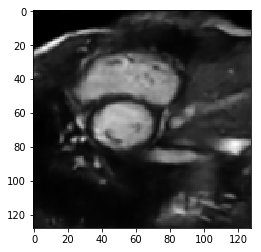

saving epoch {49}
Epoch: 50, Iteration: 1, Loss: 0.0017217157874256372, time: 2019-08-03 03:46:25.418359
Epoch: 50, Iteration: 101, Loss: 0.12196574389236048, time: 2019-08-03 03:48:06.348988
150
2019-08-03 03:48:55.802234 Epoch 50, Training loss 0.1796688965987414
torch.Size([1, 1, 128, 128, 20])


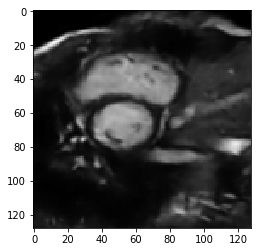

saving epoch {50}
Epoch: 51, Iteration: 1, Loss: 0.0010197247611358762, time: 2019-08-03 03:48:57.116027
Epoch: 51, Iteration: 101, Loss: 0.1197255005245097, time: 2019-08-03 03:50:38.101405
150
2019-08-03 03:51:27.553678 Epoch 51, Training loss 0.17731370340334252
torch.Size([1, 1, 128, 128, 20])


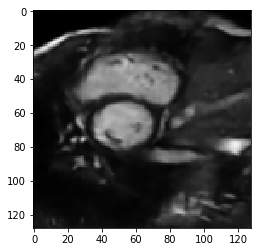

saving epoch {51}
Epoch: 52, Iteration: 1, Loss: 0.0010888364631682634, time: 2019-08-03 03:51:28.767674
Epoch: 52, Iteration: 101, Loss: 0.12582079356070608, time: 2019-08-03 03:53:09.684747
150
2019-08-03 03:53:59.135830 Epoch 52, Training loss 0.18692941882181913
torch.Size([1, 1, 128, 128, 20])


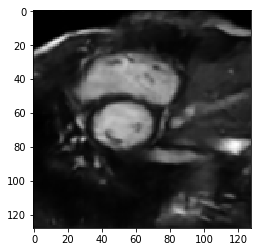

saving epoch {52}
Epoch: 53, Iteration: 1, Loss: 0.0013221090193837881, time: 2019-08-03 03:54:00.346990
Epoch: 53, Iteration: 101, Loss: 0.11276574427029118, time: 2019-08-03 03:55:41.276689
150
2019-08-03 03:56:30.763187 Epoch 53, Training loss 0.1681770947179757
torch.Size([1, 1, 128, 128, 20])


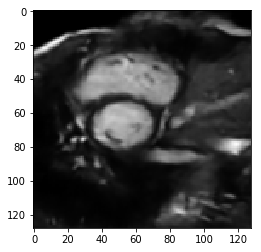

saving epoch {53}
Epoch: 54, Iteration: 1, Loss: 0.0011298907920718193, time: 2019-08-03 03:56:31.978696
Epoch: 54, Iteration: 101, Loss: 0.12300650507677346, time: 2019-08-03 03:58:12.864748
150
2019-08-03 03:59:02.331249 Epoch 54, Training loss 0.18006311764474958
torch.Size([1, 1, 128, 128, 20])


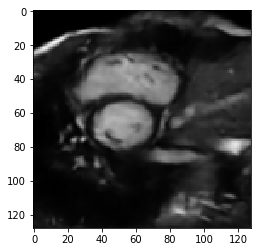

saving epoch {54}
Epoch: 55, Iteration: 1, Loss: 0.0017609350616112351, time: 2019-08-03 03:59:03.543125
Epoch: 55, Iteration: 101, Loss: 0.11340913875028491, time: 2019-08-03 04:00:44.489940
150
2019-08-03 04:01:33.941495 Epoch 55, Training loss 0.16884560702601448
torch.Size([1, 1, 128, 128, 20])


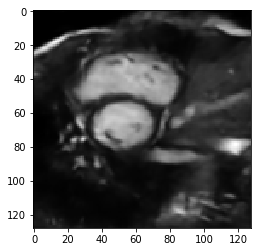

saving epoch {55}
Epoch: 56, Iteration: 1, Loss: 0.0012737489305436611, time: 2019-08-03 04:01:35.167197
Epoch: 56, Iteration: 101, Loss: 0.12724595289910212, time: 2019-08-03 04:03:16.138009
150
2019-08-03 04:04:05.595897 Epoch 56, Training loss 0.17776526312809438
torch.Size([1, 1, 128, 128, 20])


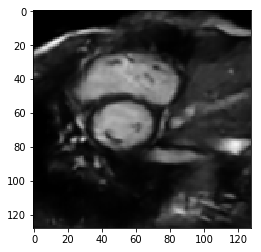

saving epoch {56}
Epoch: 57, Iteration: 1, Loss: 0.0010594811756163836, time: 2019-08-03 04:04:06.808649
Epoch: 57, Iteration: 101, Loss: 0.11962101992685348, time: 2019-08-03 04:05:47.750846
150
2019-08-03 04:06:37.195727 Epoch 57, Training loss 0.1747314477688633
torch.Size([1, 1, 128, 128, 20])


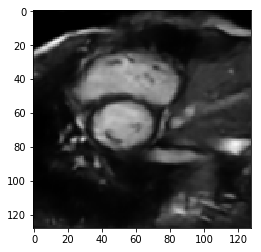

saving epoch {57}
Epoch: 58, Iteration: 1, Loss: 0.0009484388865530491, time: 2019-08-03 04:06:38.403706
Epoch: 58, Iteration: 101, Loss: 0.11685248237336054, time: 2019-08-03 04:08:19.335939
150
2019-08-03 04:09:08.799545 Epoch 58, Training loss 0.17683069041231647
torch.Size([1, 1, 128, 128, 20])


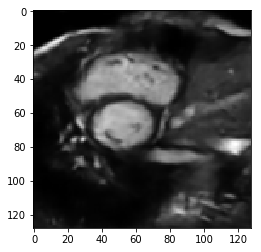

saving epoch {58}
Epoch: 59, Iteration: 1, Loss: 0.0027061535511165857, time: 2019-08-03 04:09:10.014385
Epoch: 59, Iteration: 101, Loss: 0.11474996292963624, time: 2019-08-03 04:10:50.937651
150
2019-08-03 04:11:40.441805 Epoch 59, Training loss 0.1680305713089183
torch.Size([1, 1, 128, 128, 20])


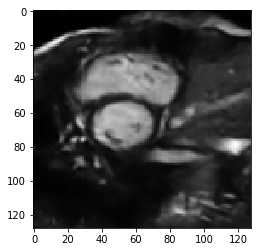

saving epoch {59}
Epoch: 60, Iteration: 1, Loss: 0.0012684179237112403, time: 2019-08-03 04:11:41.644976
Epoch: 60, Iteration: 101, Loss: 0.11463659984292462, time: 2019-08-03 04:13:22.605506
150
2019-08-03 04:14:12.045652 Epoch 60, Training loss 0.18043084495002404
torch.Size([1, 1, 128, 128, 20])


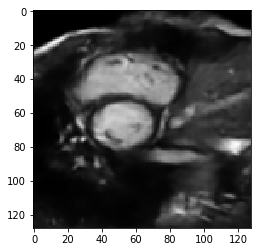

saving epoch {60}
Epoch: 61, Iteration: 1, Loss: 0.0011670624371618032, time: 2019-08-03 04:14:13.250051
Epoch: 61, Iteration: 101, Loss: 0.11182086158078164, time: 2019-08-03 04:15:54.207256
150
2019-08-03 04:16:43.652513 Epoch 61, Training loss 0.16808421054156497
torch.Size([1, 1, 128, 128, 20])


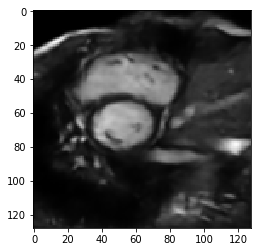

saving epoch {61}
Epoch: 62, Iteration: 1, Loss: 0.002015711273998022, time: 2019-08-03 04:16:44.869749
Epoch: 62, Iteration: 101, Loss: 0.11268487252527848, time: 2019-08-03 04:18:25.808438
150
2019-08-03 04:19:15.236395 Epoch 62, Training loss 0.1707523104851134
torch.Size([1, 1, 128, 128, 20])


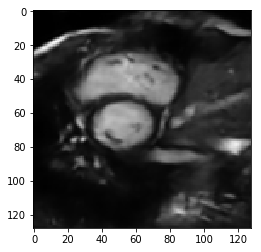

saving epoch {62}
Epoch: 63, Iteration: 1, Loss: 0.0009013310191221535, time: 2019-08-03 04:19:16.451548
Epoch: 63, Iteration: 101, Loss: 0.10935005865758285, time: 2019-08-03 04:20:57.405045
150
2019-08-03 04:21:46.926817 Epoch 63, Training loss 0.1615195040940307
torch.Size([1, 1, 128, 128, 20])


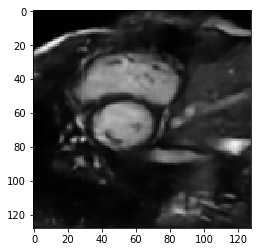

saving epoch {63}
Epoch: 64, Iteration: 1, Loss: 0.0009354277281090617, time: 2019-08-03 04:21:48.146454
Epoch: 64, Iteration: 101, Loss: 0.11842730239732191, time: 2019-08-03 04:23:29.144310
150
2019-08-03 04:24:18.659832 Epoch 64, Training loss 0.17518883215961978
torch.Size([1, 1, 128, 128, 20])


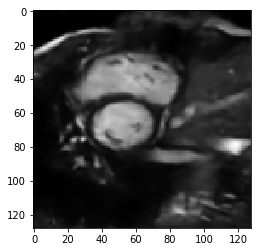

saving epoch {64}
Epoch: 65, Iteration: 1, Loss: 0.0013056083116680384, time: 2019-08-03 04:24:19.885130
Epoch: 65, Iteration: 101, Loss: 0.11136967589845881, time: 2019-08-03 04:26:00.881650
150
2019-08-03 04:26:50.376518 Epoch 65, Training loss 0.1599074907717295
torch.Size([1, 1, 128, 128, 20])


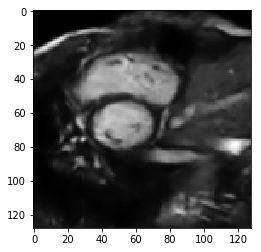

saving epoch {65}
Epoch: 66, Iteration: 1, Loss: 0.0013003874337300658, time: 2019-08-03 04:26:51.693749
Epoch: 66, Iteration: 101, Loss: 0.11826453200774267, time: 2019-08-03 04:28:32.654863
150
2019-08-03 04:29:22.137177 Epoch 66, Training loss 0.1711030340520665
torch.Size([1, 1, 128, 128, 20])


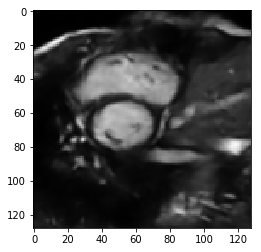

saving epoch {66}
Epoch: 67, Iteration: 1, Loss: 0.0007314906106330454, time: 2019-08-03 04:29:23.350235
Epoch: 67, Iteration: 101, Loss: 0.10392672836314887, time: 2019-08-03 04:31:04.285973
150
2019-08-03 04:31:53.756356 Epoch 67, Training loss 0.1537029220489785
torch.Size([1, 1, 128, 128, 20])


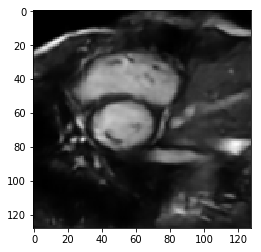

saving epoch {67}
Epoch: 68, Iteration: 1, Loss: 0.0008533681975677609, time: 2019-08-03 04:31:54.968316
Epoch: 68, Iteration: 101, Loss: 0.11672074103262275, time: 2019-08-03 04:33:35.874163
150
2019-08-03 04:34:25.345451 Epoch 68, Training loss 0.16638026508735493
torch.Size([1, 1, 128, 128, 20])


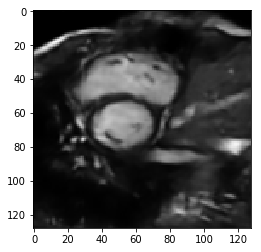

saving epoch {68}
Epoch: 69, Iteration: 1, Loss: 0.0007393354317173362, time: 2019-08-03 04:34:26.559034
Epoch: 69, Iteration: 101, Loss: 0.10420591686852276, time: 2019-08-03 04:36:07.517676
150
2019-08-03 04:36:56.998471 Epoch 69, Training loss 0.15887749625835568
torch.Size([1, 1, 128, 128, 20])


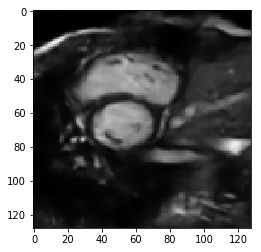

saving epoch {69}
Epoch: 70, Iteration: 1, Loss: 0.0013251834316179156, time: 2019-08-03 04:36:58.209938
Epoch: 70, Iteration: 101, Loss: 0.1064250678755343, time: 2019-08-03 04:38:39.176716
150
2019-08-03 04:39:28.650975 Epoch 70, Training loss 0.15680663636885583
torch.Size([1, 1, 128, 128, 20])


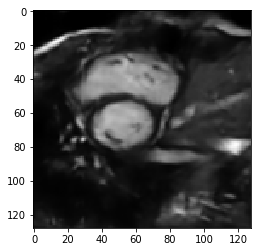

saving epoch {70}
Epoch: 71, Iteration: 1, Loss: 0.0009009105851873755, time: 2019-08-03 04:39:29.883202
Epoch: 71, Iteration: 101, Loss: 0.1055002857465297, time: 2019-08-03 04:41:10.869863
150
2019-08-03 04:42:00.337219 Epoch 71, Training loss 0.15963583916891366
torch.Size([1, 1, 128, 128, 20])


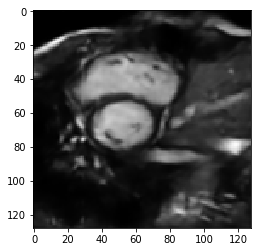

saving epoch {71}
Epoch: 72, Iteration: 1, Loss: 0.0007377898436971009, time: 2019-08-03 04:42:01.548071
Epoch: 72, Iteration: 101, Loss: 0.1140800179564394, time: 2019-08-03 04:43:42.492194
150
2019-08-03 04:44:31.971609 Epoch 72, Training loss 0.16869818756822497
torch.Size([1, 1, 128, 128, 20])


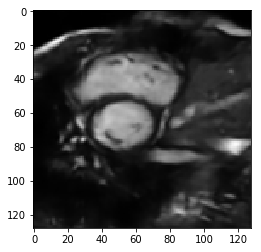

saving epoch {72}
Epoch: 73, Iteration: 1, Loss: 0.001104735187254846, time: 2019-08-03 04:44:33.198225
Epoch: 73, Iteration: 101, Loss: 0.10346103803021833, time: 2019-08-03 04:46:14.184240
150
2019-08-03 04:47:03.667314 Epoch 73, Training loss 0.158143121690955
torch.Size([1, 1, 128, 128, 20])


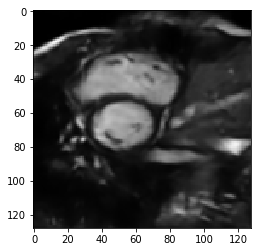

saving epoch {73}
Epoch: 74, Iteration: 1, Loss: 0.0009731469908729196, time: 2019-08-03 04:47:04.893852
Epoch: 74, Iteration: 101, Loss: 0.10370312636950985, time: 2019-08-03 04:48:45.857372
150
2019-08-03 04:49:35.313783 Epoch 74, Training loss 0.15248431375948712
torch.Size([1, 1, 128, 128, 20])


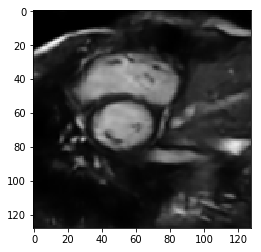

saving epoch {74}
Epoch: 75, Iteration: 1, Loss: 0.0009928528452292085, time: 2019-08-03 04:49:36.516711
Epoch: 75, Iteration: 101, Loss: 0.10511717281769961, time: 2019-08-03 04:51:17.467155
150
2019-08-03 04:52:06.952676 Epoch 75, Training loss 0.15435575495939702
torch.Size([1, 1, 128, 128, 20])


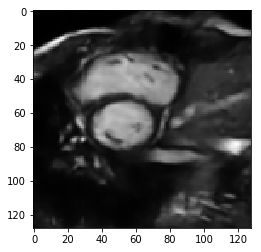

saving epoch {75}
Epoch: 76, Iteration: 1, Loss: 0.0008944094297476113, time: 2019-08-03 04:52:08.162283
Epoch: 76, Iteration: 101, Loss: 0.10116912639932707, time: 2019-08-03 04:53:49.159059
150
2019-08-03 04:54:38.667797 Epoch 76, Training loss 0.1528122771414928
torch.Size([1, 1, 128, 128, 20])


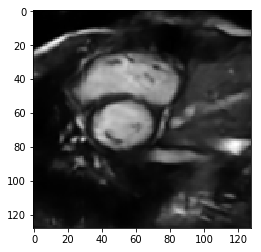

saving epoch {76}
Epoch: 77, Iteration: 1, Loss: 0.0007795559358783066, time: 2019-08-03 04:54:39.887268
Epoch: 77, Iteration: 101, Loss: 0.1112535065622069, time: 2019-08-03 04:56:20.834468
150
2019-08-03 04:57:10.298635 Epoch 77, Training loss 0.1631062917294912
torch.Size([1, 1, 128, 128, 20])


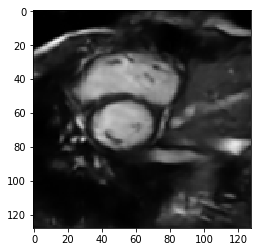

saving epoch {77}
Epoch: 78, Iteration: 1, Loss: 0.000809173914603889, time: 2019-08-03 04:57:11.512942
Epoch: 78, Iteration: 101, Loss: 0.10238258150639012, time: 2019-08-03 04:58:52.469086
150
2019-08-03 04:59:41.969178 Epoch 78, Training loss 0.15435447543859482
torch.Size([1, 1, 128, 128, 20])


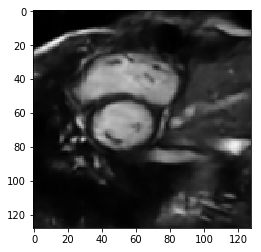

saving epoch {78}
Epoch: 79, Iteration: 1, Loss: 0.0012882791925221682, time: 2019-08-03 04:59:43.184569
Epoch: 79, Iteration: 101, Loss: 0.10094659647438675, time: 2019-08-03 05:01:24.128770
150
2019-08-03 05:02:13.589756 Epoch 79, Training loss 0.15113204857334495
torch.Size([1, 1, 128, 128, 20])


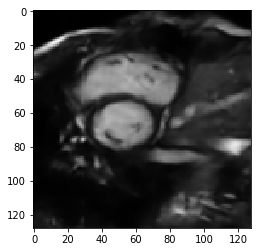

saving epoch {79}
Epoch: 80, Iteration: 1, Loss: 0.0007335910340771079, time: 2019-08-03 05:02:14.847892
Epoch: 80, Iteration: 101, Loss: 0.10342654504347593, time: 2019-08-03 05:03:55.802119
150
2019-08-03 05:04:45.243556 Epoch 80, Training loss 0.1485860969987698
torch.Size([1, 1, 128, 128, 20])


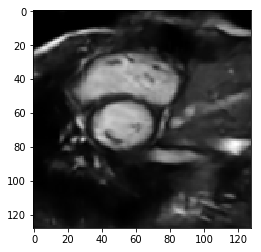

saving epoch {80}
Epoch: 81, Iteration: 1, Loss: 0.0007497916813008487, time: 2019-08-03 05:04:46.459276
Epoch: 81, Iteration: 101, Loss: 0.10992087167687714, time: 2019-08-03 05:06:27.439526
150
2019-08-03 05:07:16.938397 Epoch 81, Training loss 0.1600097927148454
torch.Size([1, 1, 128, 128, 20])


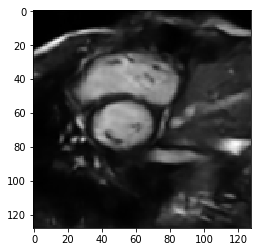

saving epoch {81}
Epoch: 82, Iteration: 1, Loss: 0.001483825035393238, time: 2019-08-03 05:07:18.153201
Epoch: 82, Iteration: 101, Loss: 0.09819252957822755, time: 2019-08-03 05:08:59.105549
150
2019-08-03 05:09:48.562916 Epoch 82, Training loss 0.15111049730330706
torch.Size([1, 1, 128, 128, 20])


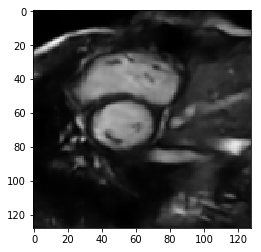

saving epoch {82}
Epoch: 83, Iteration: 1, Loss: 0.0012500559678301215, time: 2019-08-03 05:09:49.876845
Epoch: 83, Iteration: 101, Loss: 0.09509542200248688, time: 2019-08-03 05:11:30.837098
150
2019-08-03 05:12:20.329200 Epoch 83, Training loss 0.14678368292516097
torch.Size([1, 1, 128, 128, 20])


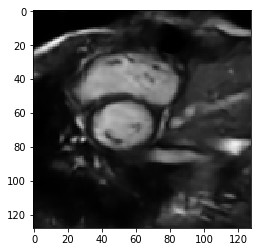

saving epoch {83}
Epoch: 84, Iteration: 1, Loss: 0.000556051847524941, time: 2019-08-03 05:12:21.661290
Epoch: 84, Iteration: 101, Loss: 0.10525935923215002, time: 2019-08-03 05:14:02.615025
150
2019-08-03 05:14:52.087343 Epoch 84, Training loss 0.14737896609585732
torch.Size([1, 1, 128, 128, 20])


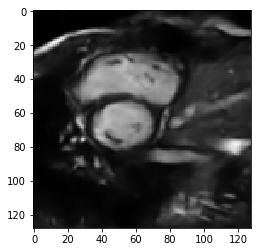

saving epoch {84}
Epoch: 85, Iteration: 1, Loss: 0.0008084446890279651, time: 2019-08-03 05:14:53.301305
Epoch: 85, Iteration: 101, Loss: 0.10030106059275568, time: 2019-08-03 05:16:34.321325
150
2019-08-03 05:17:23.821469 Epoch 85, Training loss 0.14585420436924323
torch.Size([1, 1, 128, 128, 20])


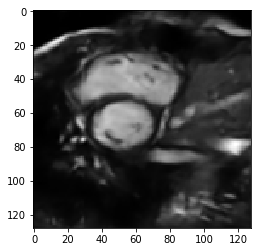

saving epoch {85}
Epoch: 86, Iteration: 1, Loss: 0.0010560882510617375, time: 2019-08-03 05:17:25.042894
Epoch: 86, Iteration: 101, Loss: 0.10170154366642237, time: 2019-08-03 05:19:06.013906
150
2019-08-03 05:19:55.480526 Epoch 86, Training loss 0.15002894133795053
torch.Size([1, 1, 128, 128, 20])


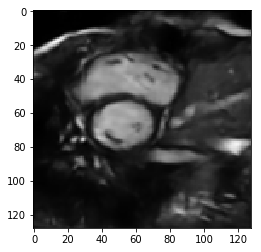

saving epoch {86}
Epoch: 87, Iteration: 1, Loss: 0.0007808997761458158, time: 2019-08-03 05:19:56.695190
Epoch: 87, Iteration: 101, Loss: 0.10371160937938839, time: 2019-08-03 05:21:37.651726
150
2019-08-03 05:22:27.120160 Epoch 87, Training loss 0.15118714788695797
torch.Size([1, 1, 128, 128, 20])


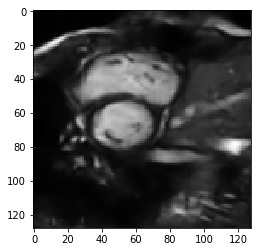

saving epoch {87}
Epoch: 88, Iteration: 1, Loss: 0.0006781683187000453, time: 2019-08-03 05:22:28.381482
Epoch: 88, Iteration: 101, Loss: 0.09517209441401064, time: 2019-08-03 05:24:09.371305
150
2019-08-03 05:24:58.861418 Epoch 88, Training loss 0.14603649073978886
torch.Size([1, 1, 128, 128, 20])


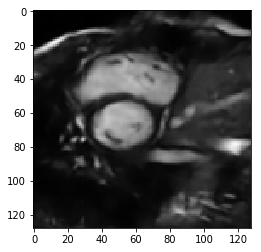

saving epoch {88}
Epoch: 89, Iteration: 1, Loss: 0.0010276020038872957, time: 2019-08-03 05:25:00.077303
Epoch: 89, Iteration: 101, Loss: 0.09566150681348518, time: 2019-08-03 05:26:41.031112
150
2019-08-03 05:27:30.501320 Epoch 89, Training loss 0.1479973234818317
torch.Size([1, 1, 128, 128, 20])


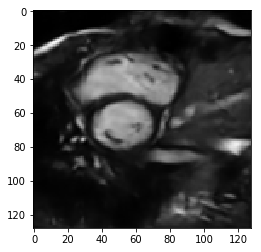

saving epoch {89}
Epoch: 90, Iteration: 1, Loss: 0.0011738920584321022, time: 2019-08-03 05:27:31.721710
Epoch: 90, Iteration: 101, Loss: 0.09862747276201844, time: 2019-08-03 05:29:12.677831
150
2019-08-03 05:30:02.157867 Epoch 90, Training loss 0.14578730327775702
torch.Size([1, 1, 128, 128, 20])


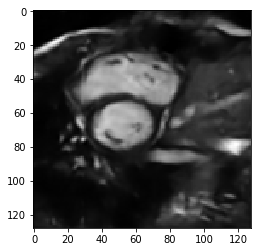

saving epoch {90}
Epoch: 91, Iteration: 1, Loss: 0.001323606469668448, time: 2019-08-03 05:30:03.372403
Epoch: 91, Iteration: 101, Loss: 0.10413401934783906, time: 2019-08-03 05:31:44.337883
150
2019-08-03 05:32:33.766054 Epoch 91, Training loss 0.14930113666923717
torch.Size([1, 1, 128, 128, 20])


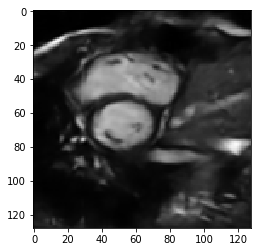

saving epoch {91}
Epoch: 92, Iteration: 1, Loss: 0.0006253872998058796, time: 2019-08-03 05:32:34.989601
Epoch: 92, Iteration: 101, Loss: 0.09744894847972319, time: 2019-08-03 05:34:15.952243
150
2019-08-03 05:35:05.394358 Epoch 92, Training loss 0.14581729867495596
torch.Size([1, 1, 128, 128, 20])


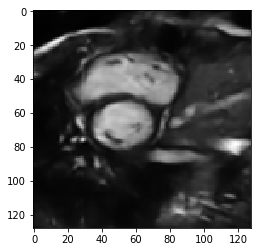

saving epoch {92}
Epoch: 93, Iteration: 1, Loss: 0.0007553226314485073, time: 2019-08-03 05:35:06.604737
Epoch: 93, Iteration: 101, Loss: 0.09792878670850769, time: 2019-08-03 05:36:47.566853
150
2019-08-03 05:37:37.037338 Epoch 93, Training loss 0.14381850563222542
torch.Size([1, 1, 128, 128, 20])


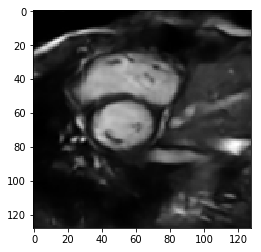

saving epoch {93}
Epoch: 94, Iteration: 1, Loss: 0.0009415323729626834, time: 2019-08-03 05:37:38.244523
Epoch: 94, Iteration: 101, Loss: 0.09419430332491174, time: 2019-08-03 05:39:19.211400
150
2019-08-03 05:40:08.697286 Epoch 94, Training loss 0.14214322750922292
torch.Size([1, 1, 128, 128, 20])


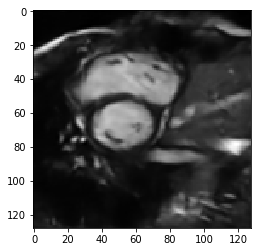

saving epoch {94}
Epoch: 95, Iteration: 1, Loss: 0.000886892550624907, time: 2019-08-03 05:40:09.919691
Epoch: 95, Iteration: 101, Loss: 0.0928245292743668, time: 2019-08-03 05:41:50.889230
150
2019-08-03 05:42:40.363836 Epoch 95, Training loss 0.13877091091126204
torch.Size([1, 1, 128, 128, 20])


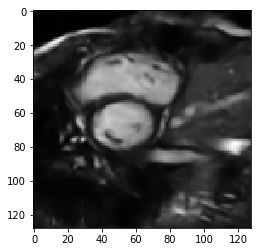

saving epoch {95}
Epoch: 96, Iteration: 1, Loss: 0.0006265413830988109, time: 2019-08-03 05:42:41.577333
Epoch: 96, Iteration: 101, Loss: 0.08775404948391952, time: 2019-08-03 05:44:22.561344
150
2019-08-03 05:45:12.052124 Epoch 96, Training loss 0.13391929186764173
torch.Size([1, 1, 128, 128, 20])


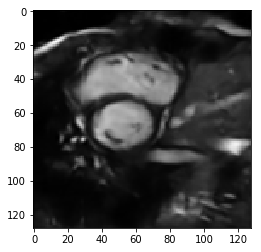

saving epoch {96}
Epoch: 97, Iteration: 1, Loss: 0.0007041539647616446, time: 2019-08-03 05:45:13.270630
Epoch: 97, Iteration: 101, Loss: 0.08968841069145128, time: 2019-08-03 05:46:54.269657
150
2019-08-03 05:47:43.763020 Epoch 97, Training loss 0.13396722223842517
torch.Size([1, 1, 128, 128, 20])


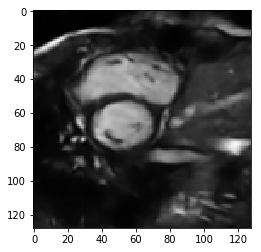

saving epoch {97}
Epoch: 98, Iteration: 1, Loss: 0.0007535344338975847, time: 2019-08-03 05:47:44.983365
Epoch: 98, Iteration: 101, Loss: 0.09903639293042943, time: 2019-08-03 05:49:25.977386
150
2019-08-03 05:50:15.454701 Epoch 98, Training loss 0.14350789145100862
torch.Size([1, 1, 128, 128, 20])


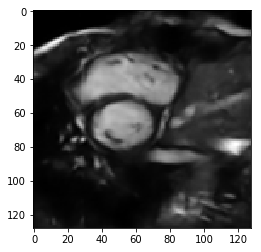

saving epoch {98}
Epoch: 99, Iteration: 1, Loss: 0.0006802052957937121, time: 2019-08-03 05:50:16.762363
Epoch: 99, Iteration: 101, Loss: 0.0966192776686512, time: 2019-08-03 05:51:57.783552
150
2019-08-03 05:52:47.298836 Epoch 99, Training loss 0.138996779860463
torch.Size([1, 1, 128, 128, 20])


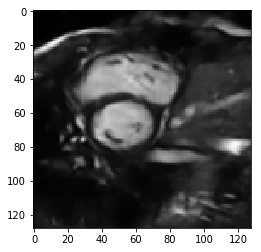

saving epoch {99}
Epoch: 100, Iteration: 1, Loss: 0.0006738509982824326, time: 2019-08-03 05:52:48.511058
Epoch: 100, Iteration: 101, Loss: 0.09125629207119346, time: 2019-08-03 05:54:29.465888
150
2019-08-03 05:55:18.959393 Epoch 100, Training loss 0.13248614443000406
torch.Size([1, 1, 128, 128, 20])


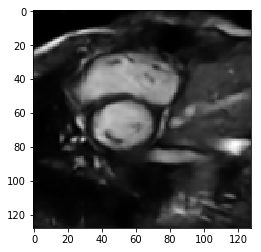

saving epoch {100}


In [41]:
training_loop(100, optimizer, model, loss_fn, train_loader)

# Training done

# Testing and Visualisation

In [46]:
result_vec = []

In [47]:
for k in range(222):
    a = test_recon[k:k+1,:,:,:,:]
    a = a.float()
    result = model(a.to(device))
    result = result.to('cpu')
    result = result.detach()
    result = result.numpy()
    result_vec.append(result)

In [48]:
len(result_vec)

222

In [49]:
res_save = np.ndarray((128,128,200,222))

In [50]:
a = torch.FloatTensor(result_vec)

In [51]:
a.shape

torch.Size([222, 1, 1, 128, 128, 20])

In [52]:
a = a.permute(0,3,4,5,1,2)

In [53]:
b = a[:,:,:,:,0,0]

In [54]:
b.shape

torch.Size([222, 128, 128, 20])

In [55]:
b = b.numpy()

In [56]:
import scipy.io

In [57]:
scipy.io.savemat('Results_unet_23und_100epoch.mat', {'recon':b})

In [58]:
result_vec[0].shape

(1, 1, 128, 128, 20)

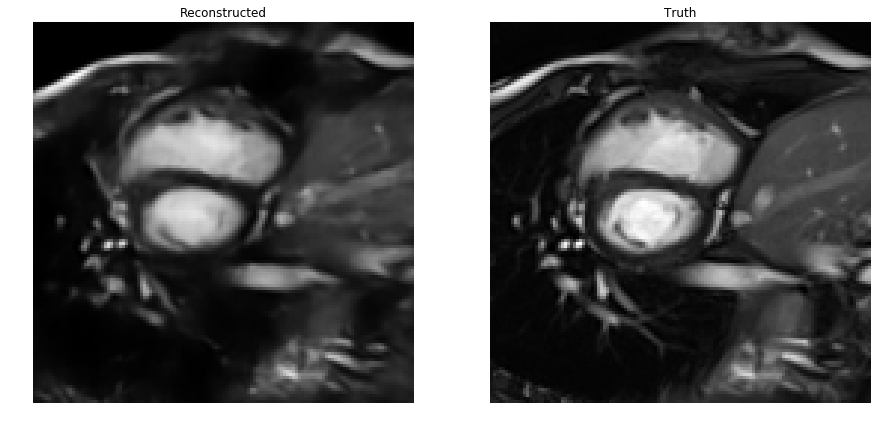

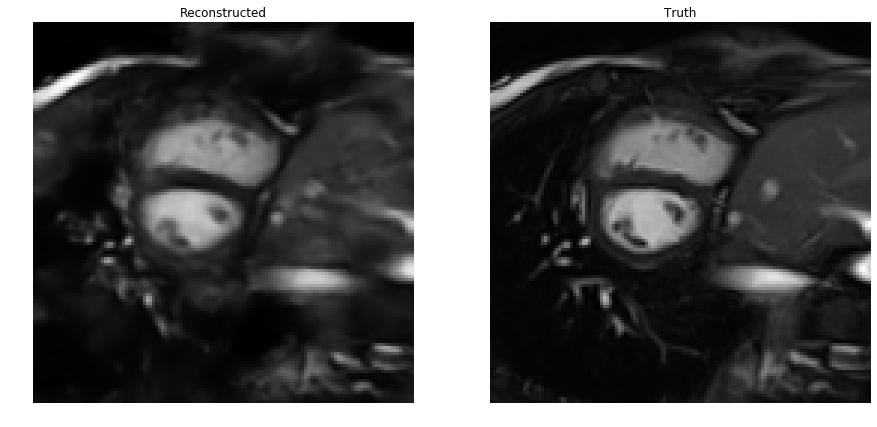

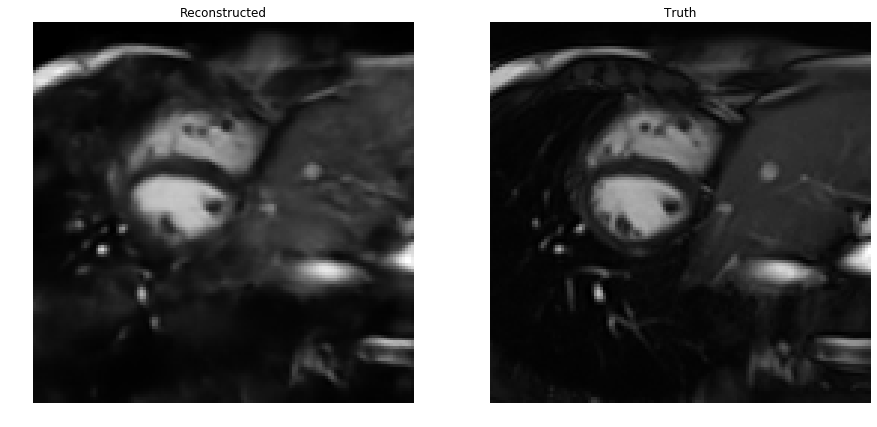

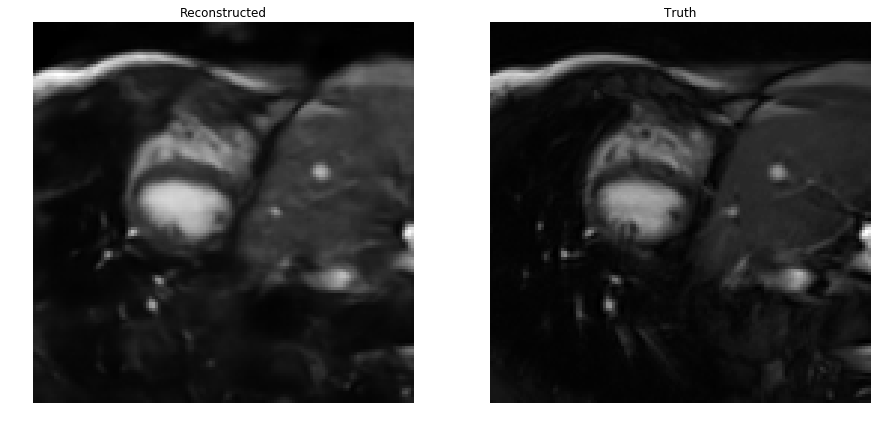

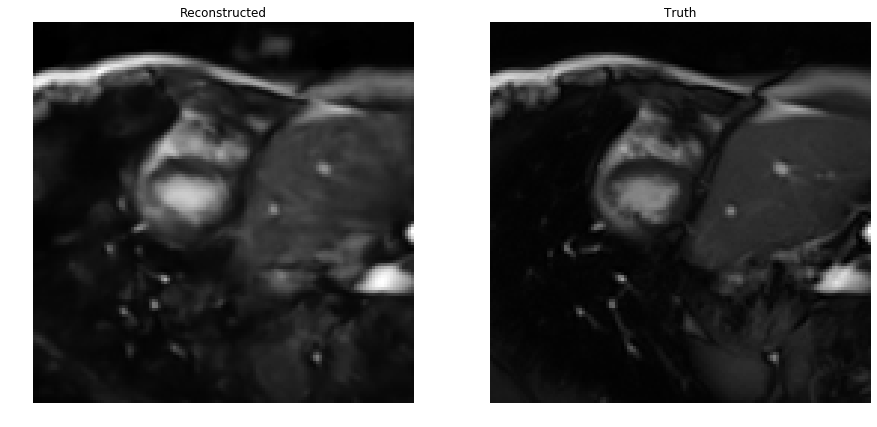

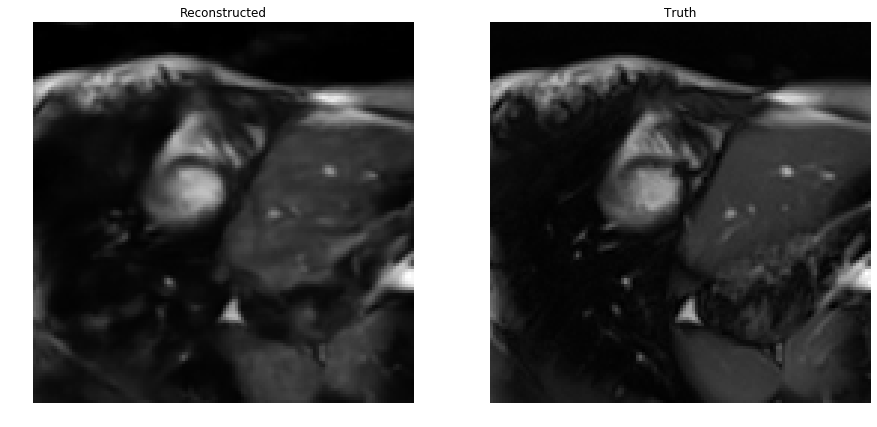

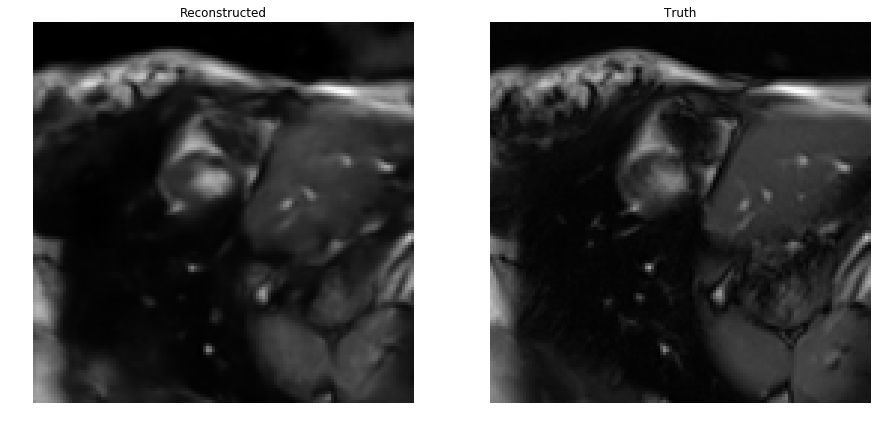

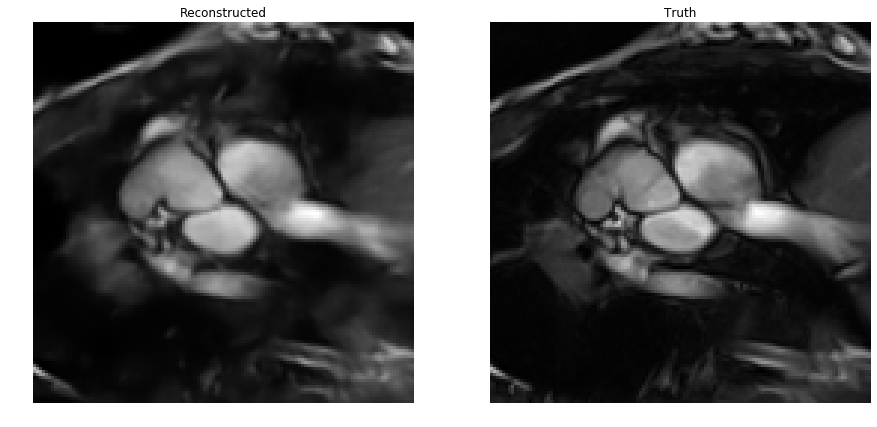

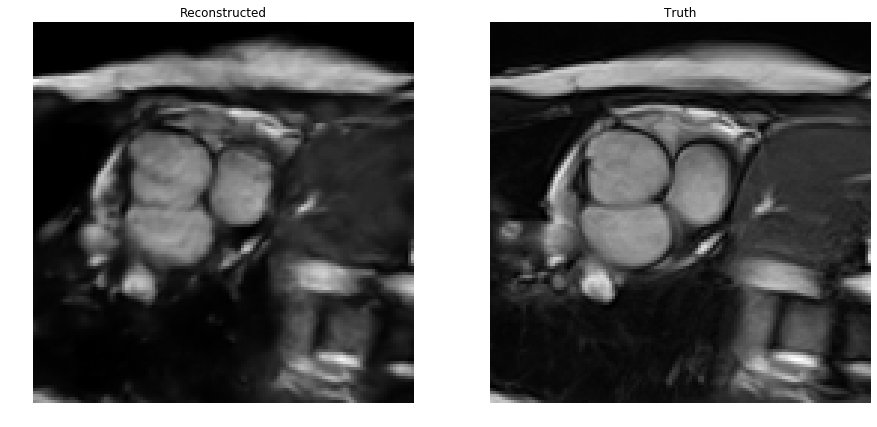

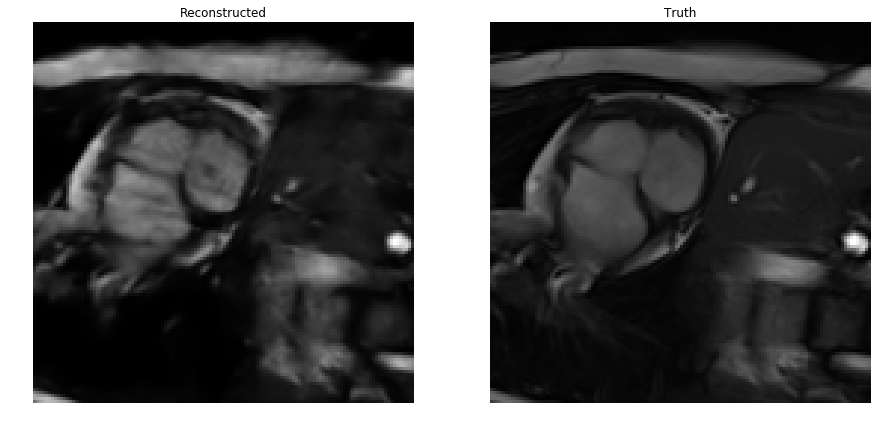

In [59]:
for k in range(10):
# Let's look at a smaple data again to check everything is the same
    f, arr = plt.subplots(1,2,figsize=(15,15))
    arr[0].imshow(result_vec[k][0,0,:,:,10], cmap='gray')
    arr[0].set_title("Reconstructed")
    arr[0].axis('off')
    arr[1].imshow(test_truth[k,0,:,:,10], cmap='gray')
    arr[1].set_title("Truth")
    arr[1].axis('off');

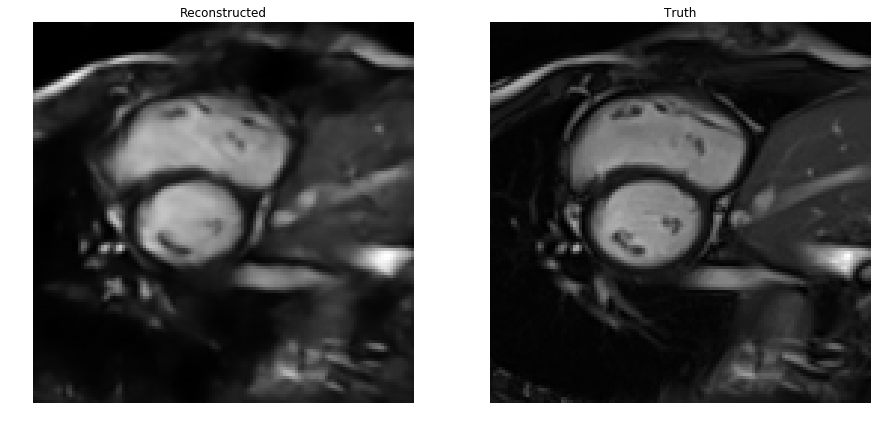

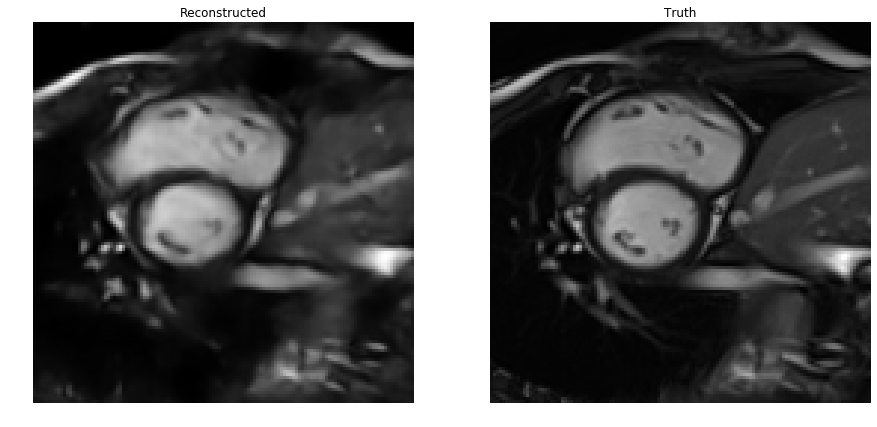

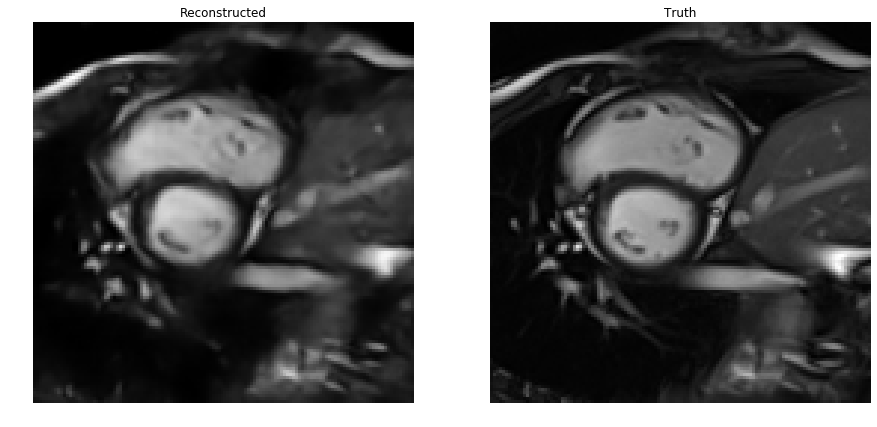

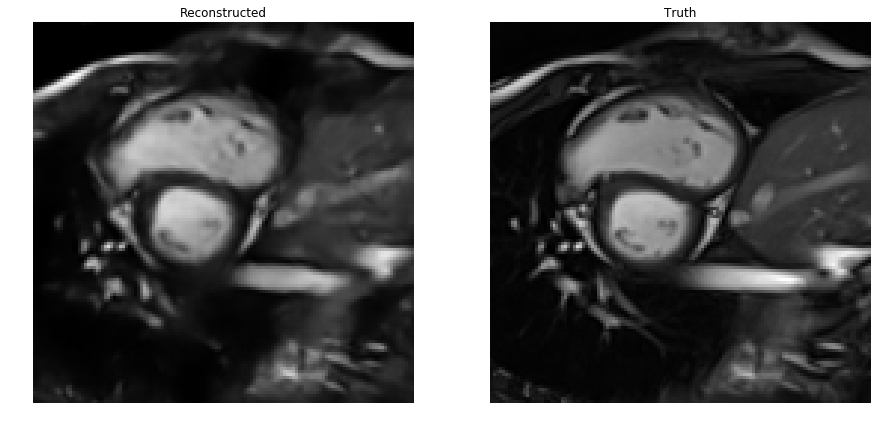

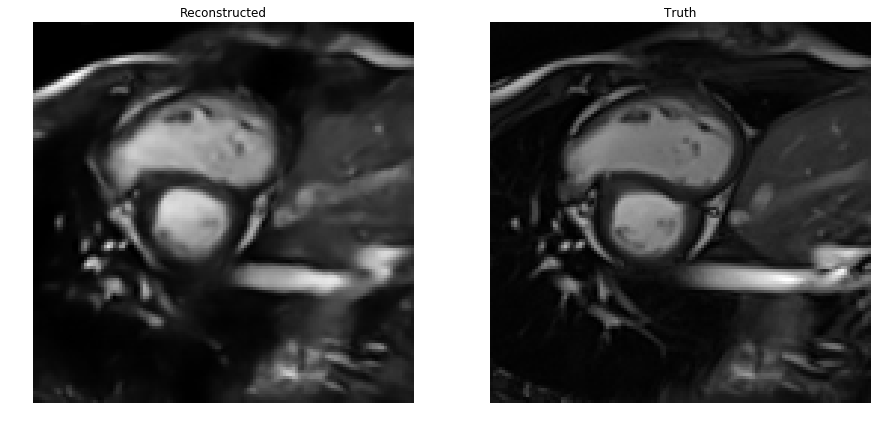

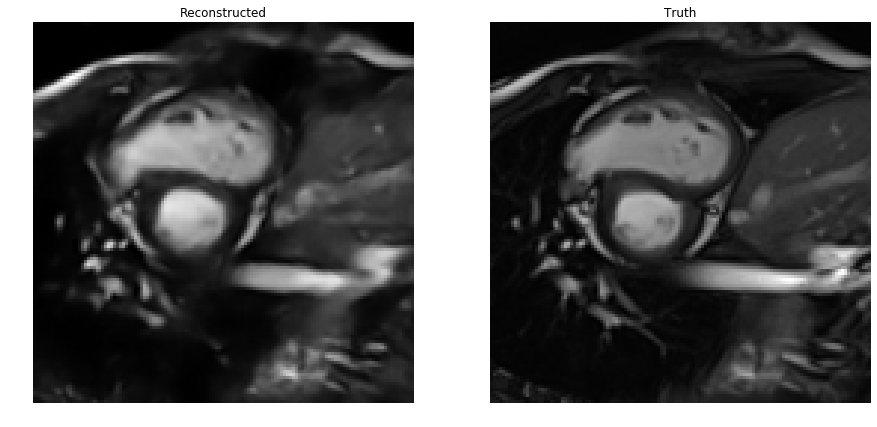

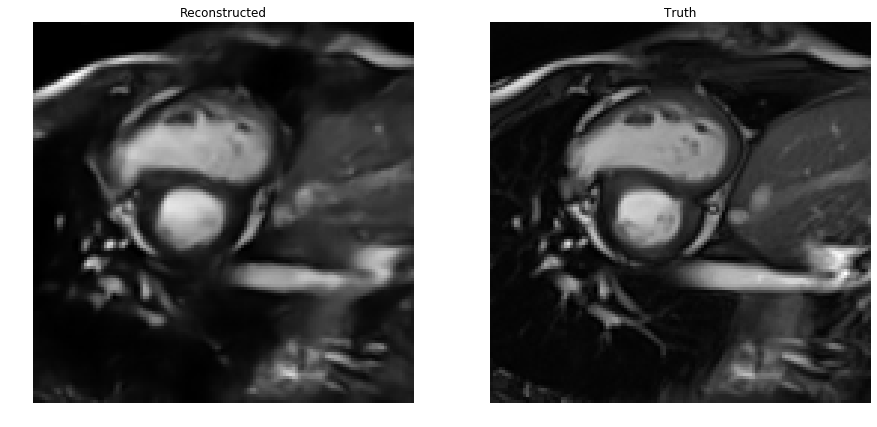

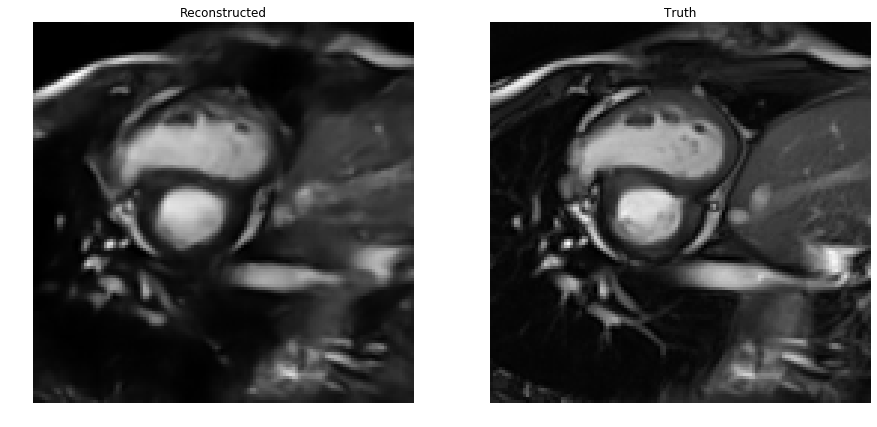

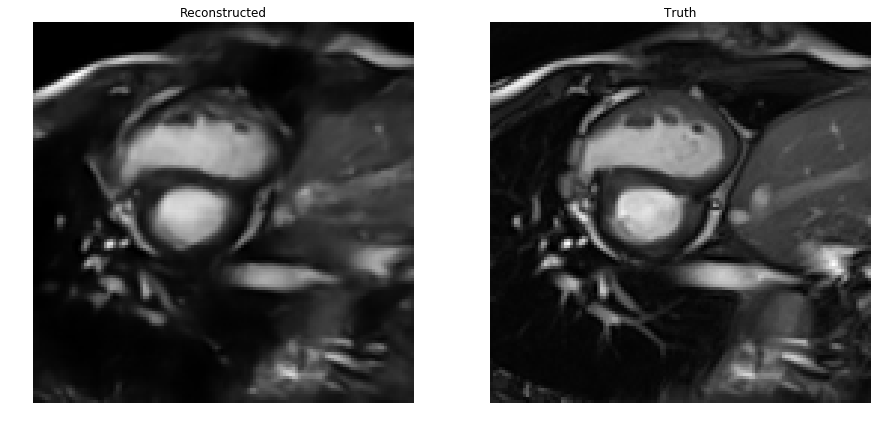

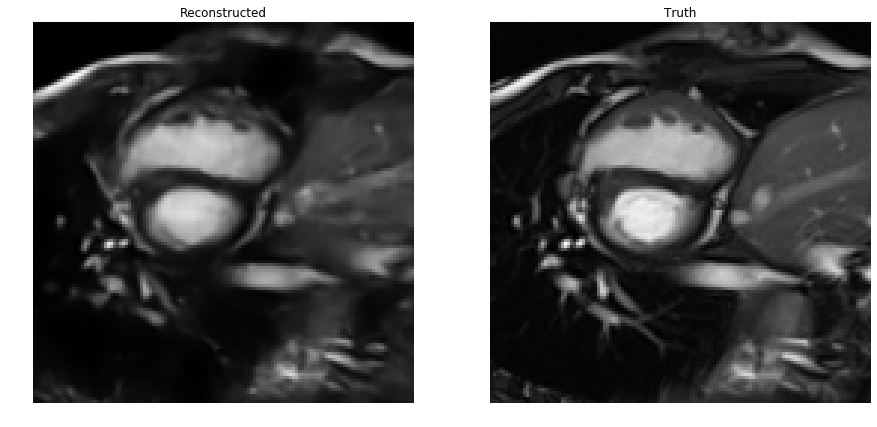

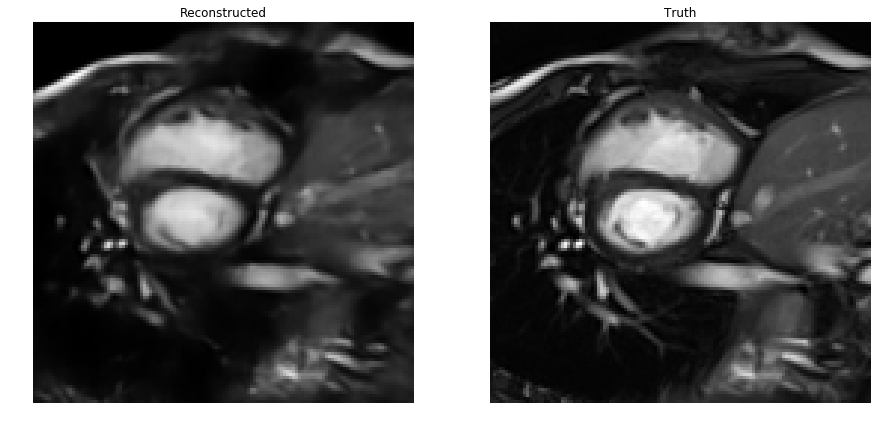

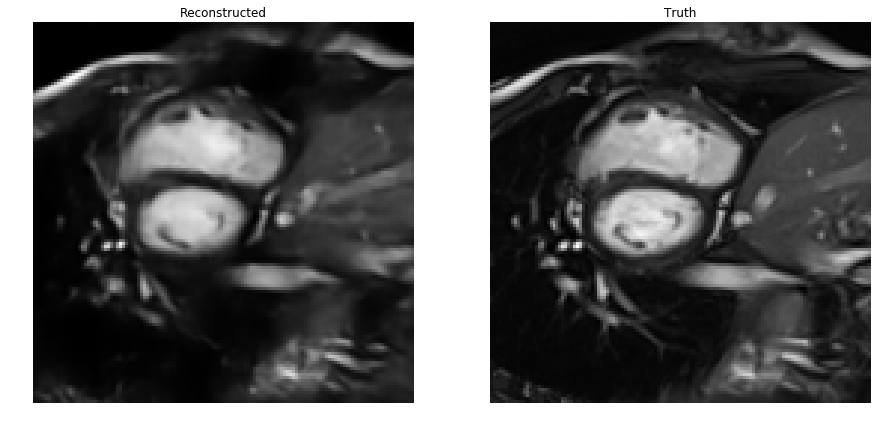

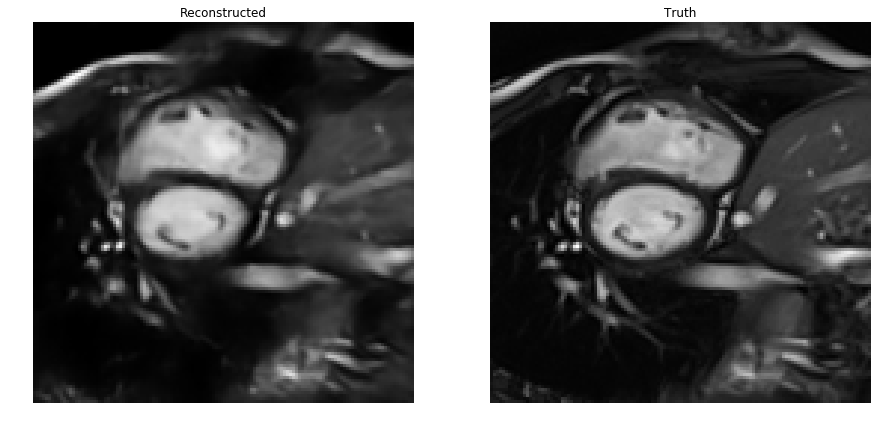

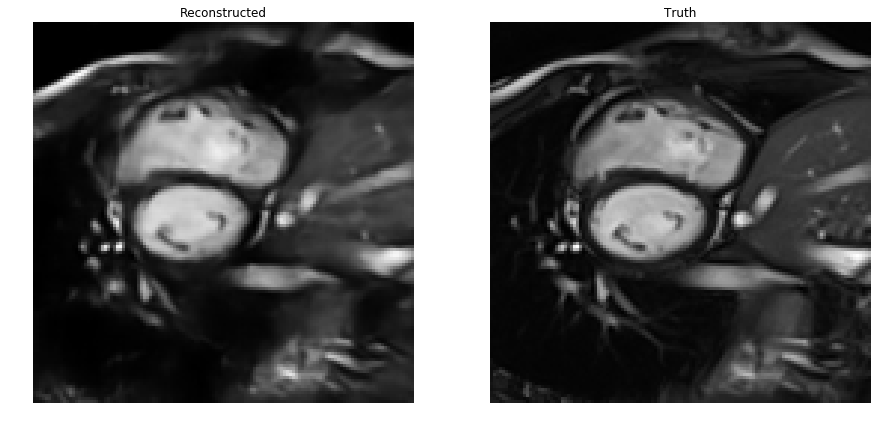

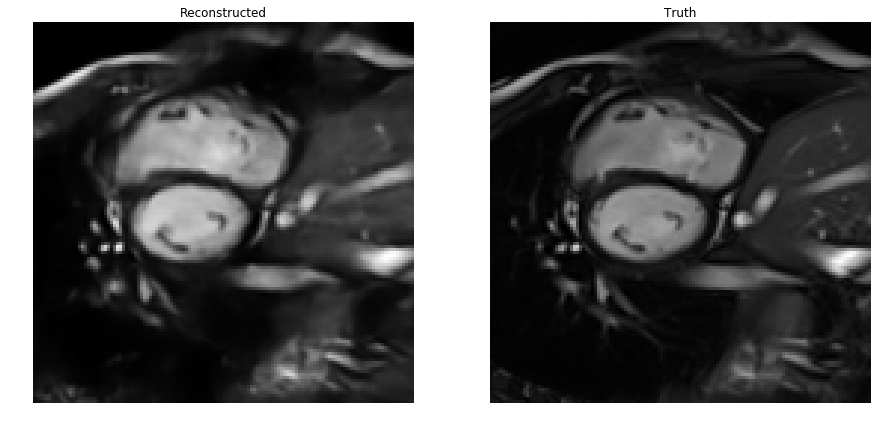

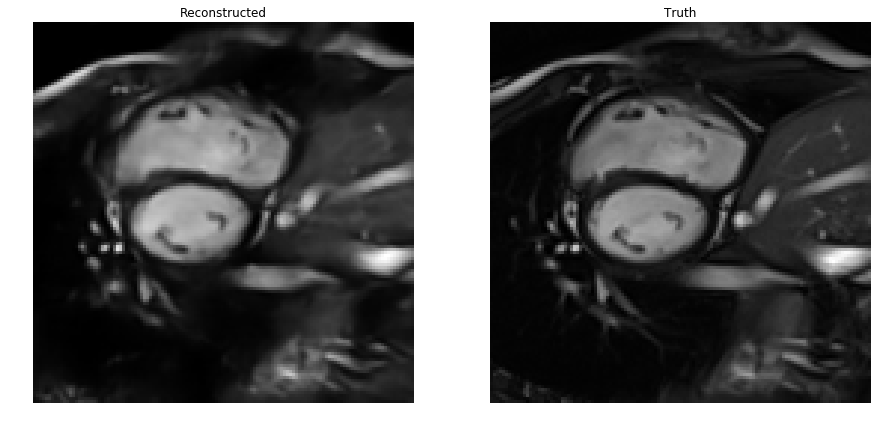

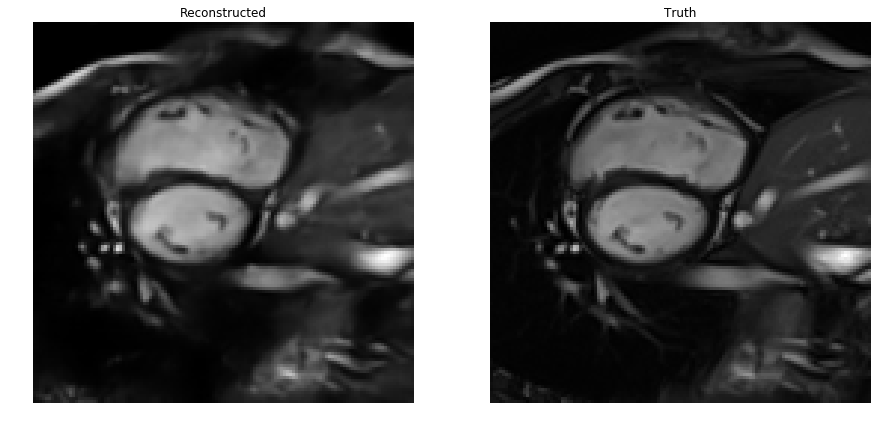

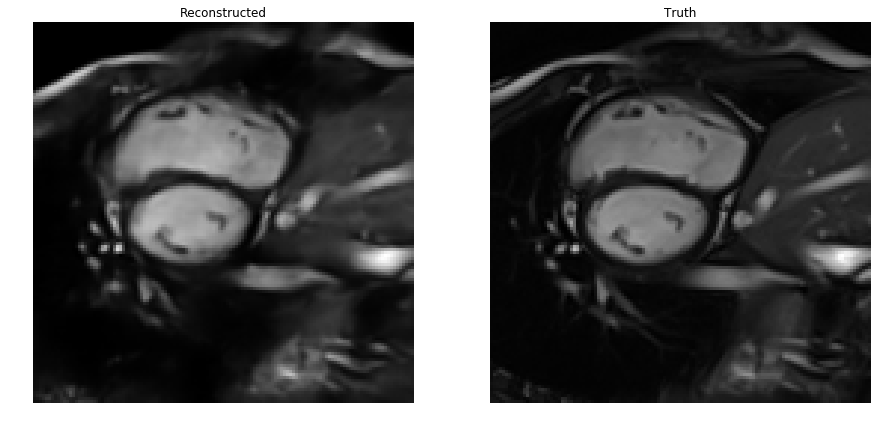

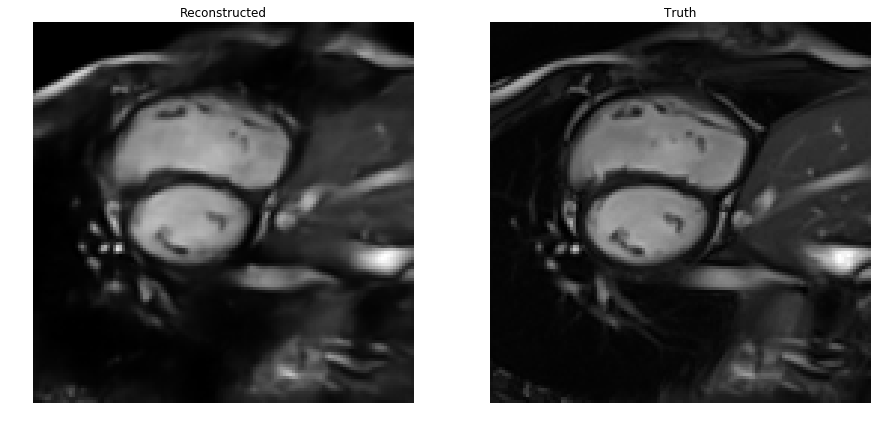

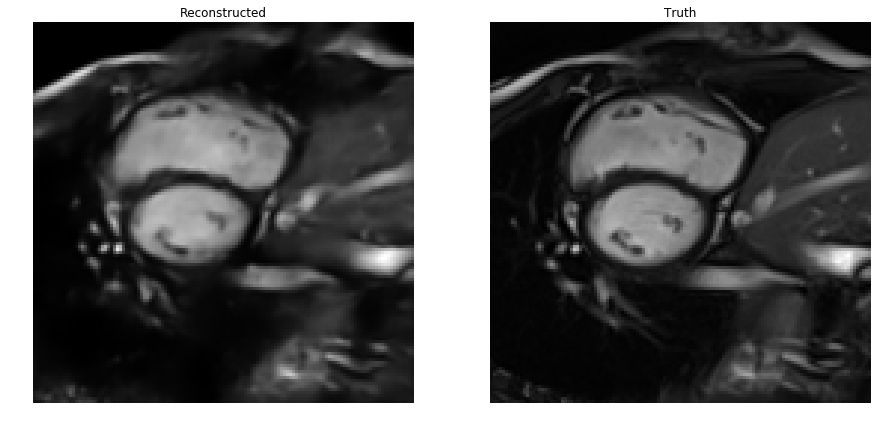

In [60]:
for k in range(20):
# Let's look at a smaple data again to check everything is the same
    f, arr = plt.subplots(1,2,figsize=(15,15))
    arr[0].imshow(result_vec[0][0,0,:,:,k], cmap='gray')
    arr[0].set_title("Reconstructed")
    arr[0].axis('off')
    arr[1].imshow(test_truth[0,0,:,:,k], cmap='gray')
    arr[1].set_title("Truth")
    arr[1].axis('off');